# Exploratory Data Analysis

In this section, we will perform data profiling on the training dataset - `customer.csv`.
The objective of this section is to understand the data that will be used to train the model, making use of statistics and visualizations, in order to identify potential issues that need to be addressed in the data preprocessing section.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/customer.csv')
rows,features = df.shape
print(f"Data set has {rows} rows with {features} features\n")
print(f"Features:")
list(df.columns)

Data set has 72458 rows with 15 features

Features:


['Unnamed: 0',
 'custid',
 'sex',
 'is_employed',
 'income',
 'marital_status',
 'health_ins',
 'housing_type',
 'num_vehicles',
 'age',
 'state_of_res',
 'code_column',
 'gas_usage',
 'rooms',
 'recent_move_b']

In [3]:
print(df.isnull().sum())
t_sum = df.isnull().sum().sum()
percentual = t_sum/(len(df)*len(df.columns))*100
print(f'\nTotal NaN values {t_sum}')
print(f'{percentual}% of missing values')
print(f'Total Duplicated rows {df.duplicated().sum()}')

Unnamed: 0            0
custid                0
sex                   0
is_employed       25515
income                0
marital_status        0
health_ins            0
housing_type       1686
num_vehicles       1686
age                   0
state_of_res          0
code_column           0
gas_usage          1686
rooms                 0
recent_move_b      1687
dtype: int64

Total NaN values 32260
2.968156265238713% of missing values
Total Duplicated rows 0


As we can see the DataSet have 32260 missing values ​​this corresponds to approximately 2.97% of the values, most of them in is_emplyed.
There are no duplicated rows.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72458 entries, 0 to 72457
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      72458 non-null  int64  
 1   custid          72458 non-null  object 
 2   sex             72458 non-null  object 
 3   is_employed     46943 non-null  object 
 4   income          72458 non-null  float64
 5   marital_status  72458 non-null  object 
 6   health_ins      72458 non-null  bool   
 7   housing_type    70772 non-null  object 
 8   num_vehicles    70772 non-null  float64
 9   age             72458 non-null  int64  
 10  state_of_res    72458 non-null  object 
 11  code_column     72458 non-null  int64  
 12  gas_usage       70772 non-null  float64
 13  rooms           72458 non-null  int64  
 14  recent_move_b   70771 non-null  object 
dtypes: bool(1), float64(3), int64(4), object(7)
memory usage: 7.8+ MB


now let's analyze each feature, as custid and unnamed have no duplicate or missing values, and both correspond to the row and id respectively, we will not analyze them because they are useless for the evaluation.

## Sex

In [5]:
df['sex'].describe()

count      72458
unique         2
top       Female
freq       37461
Name: sex, dtype: object

sex
Female            37461
Male              34997
Missing values        0
Name: count, dtype: int64


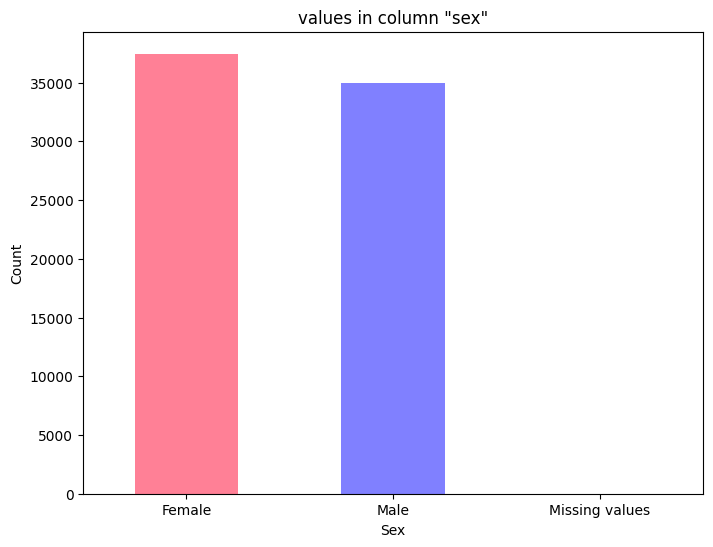

In [6]:
sex_counts = df['sex'].value_counts()
sex_counts['Missing values'] = df['sex'].isnull().sum()
print(sex_counts)
plt.figure(figsize=(8, 6)) 
sex_counts.plot(kind='bar',color=['#FF8096','#8080FF'])
plt.title('values in column "sex"')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The data is balanced and there are no missing values.

## is_imployed

In [7]:
df['is_employed'].describe()

count     46943
unique        2
top        True
freq      44630
Name: is_employed, dtype: object

is_employed
True              44630
False              2313
Missing values    25515
Name: count, dtype: int64


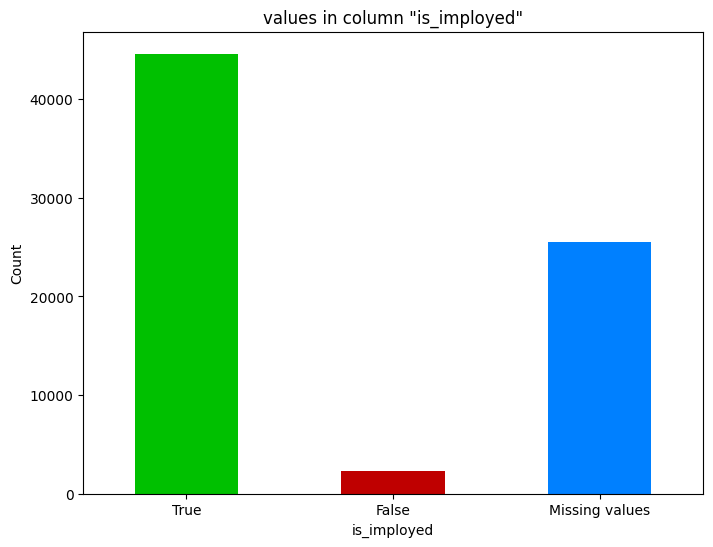

In [8]:
is_imployed_counts = df['is_employed'].value_counts()
is_imployed_counts['Missing values'] = df['is_employed'].isnull().sum()
print(is_imployed_counts)
plt.figure(figsize=(8, 6)) 
is_imployed_counts.plot(kind='bar',color=['#00C000','#BF0000','#0080FF'])
plt.title('values in column "is_imployed"')
plt.xlabel('is_imployed')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The data is not balanced and there are 25515 missing values, which is not good.

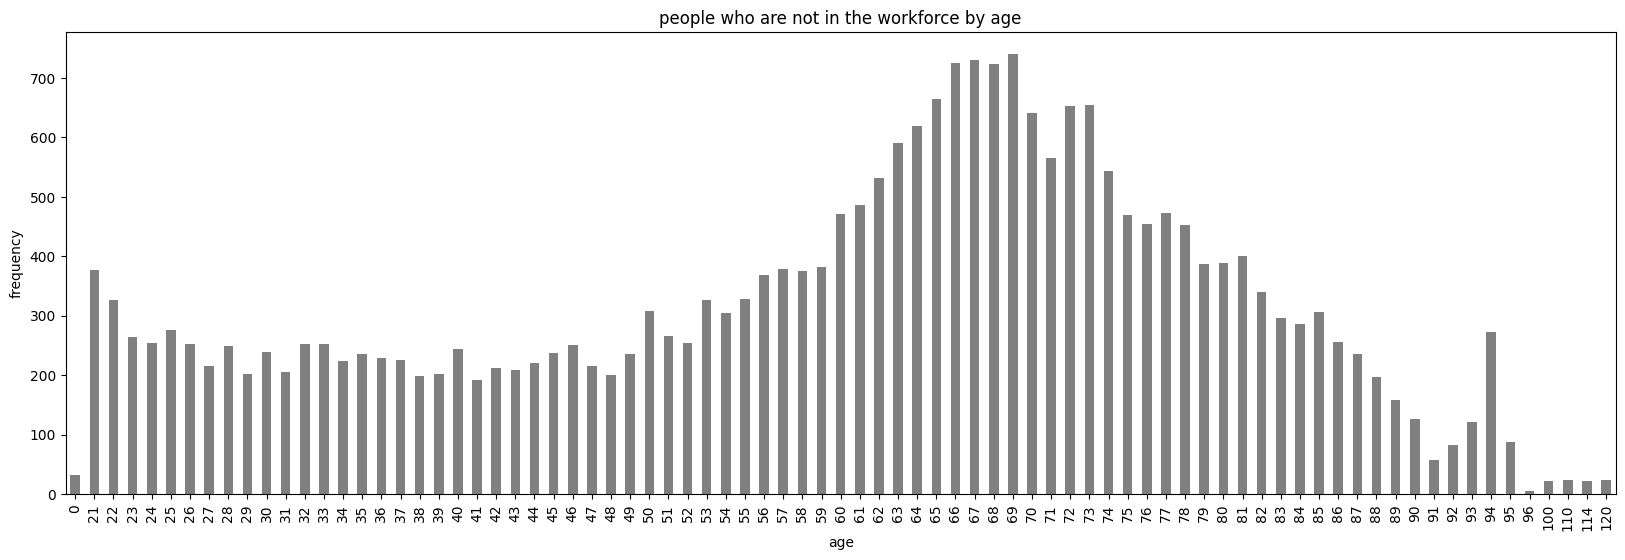

In [9]:
df_nan_isemployed = df[df['is_employed'].isnull()]
age_in_is_imployed_missing_values_counts = df_nan_isemployed['age'].value_counts()
age_in_is_imployed_missing_values_counts = age_in_is_imployed_missing_values_counts.sort_index()
plt.figure(figsize=(20, 6)) 
age_in_is_imployed_missing_values_counts.plot(kind='bar',color=['gray'])
plt.title('people who are not in the workforce by age')
plt.xlabel('age')
plt.ylabel('frequency')
plt.xticks(rotation=90)
plt.show()

we can see that the null values ​​extend across all ages

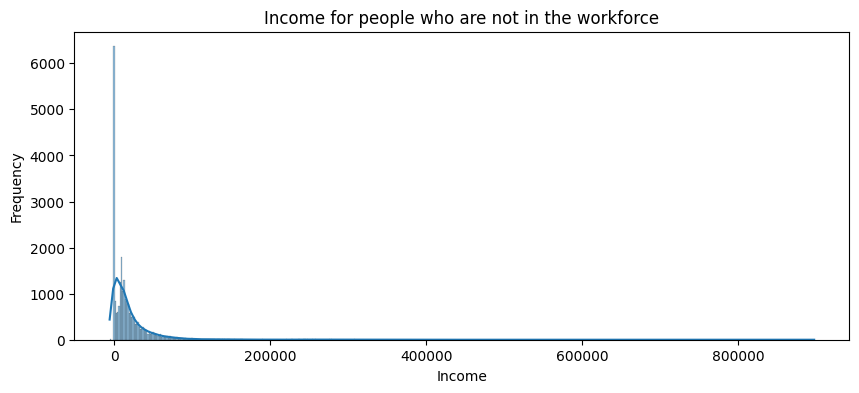

In [10]:
plt.figure(figsize=(10, 4))
sns.histplot(df_nan_isemployed['income'].dropna(), kde=True)
plt.title("Income for people who are not in the workforce") 
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

Some of them have income 

## Income

In [11]:
df['income'].describe()

count    7.245800e+04
mean     4.188143e+04
std      5.827460e+04
min     -6.900000e+03
25%      1.070000e+04
50%      2.640000e+04
75%      5.200000e+04
max      1.257000e+06
Name: income, dtype: float64

In [12]:
df[df['income'] < 0].head()

,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
379,542,000582425_02,Male,True,-1500.0,Married,True,Homeowner free and clear,5.0,61,Alabama,1047,50.0,3,F
557,780,000841705_03,Female,True,-6800.0,Married,True,Homeowner free and clear,2.0,60,Alabama,1047,3.0,5,F
1281,1808,000078804_02,Male,True,-4500.0,Married,True,Homeowner with mortgage/loan,2.0,36,Arizona,1534,40.0,3,F
2968,4199,000616218_01,Male,True,-6900.0,Married,True,Rented,2.0,120,Arkansas,653,60.0,2,F
8089,11343,000819312_01,Male,True,-5800.0,Married,False,Homeowner free and clear,6.0,22,California,8962,60.0,4,F


Maybe negative values for income are errors

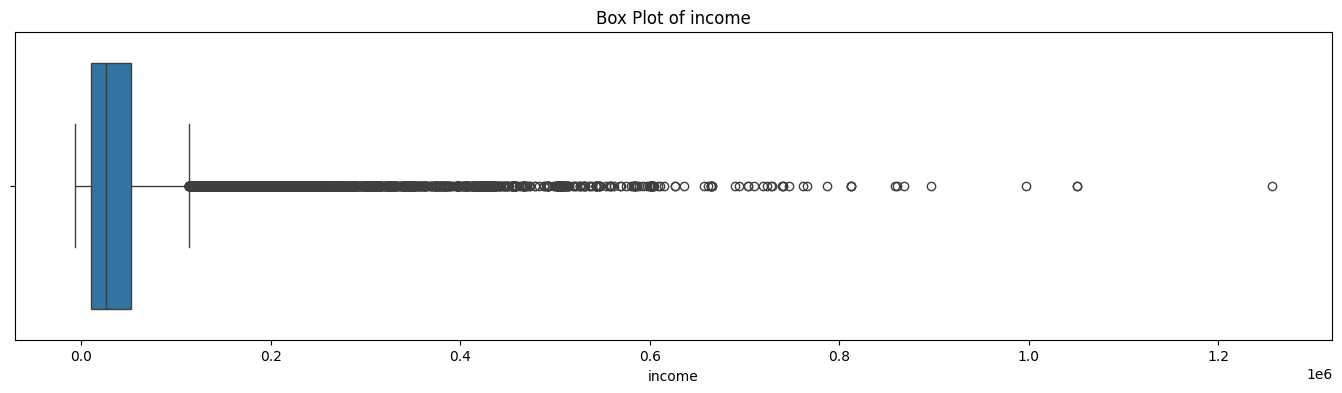

In [13]:
plt.figure(figsize=(17, 4))
sns.boxplot(x=df['income'])
plt.title(f'Box Plot of income')
plt.show()

Income have a lot of outliers and his distribution is not a normal distribution 

## Marital_status

In [14]:
print(df['marital_status'].unique())
print(df['marital_status'].describe())

['Never married' 'Divorced/Separated' 'Widowed' 'Married']
count       72458
unique          4
top       Married
freq        38040
Name: marital_status, dtype: object


marital_status
Married               38040
Never married         19120
Divorced/Separated    10572
Widowed                4726
Missing values            0
Name: count, dtype: int64


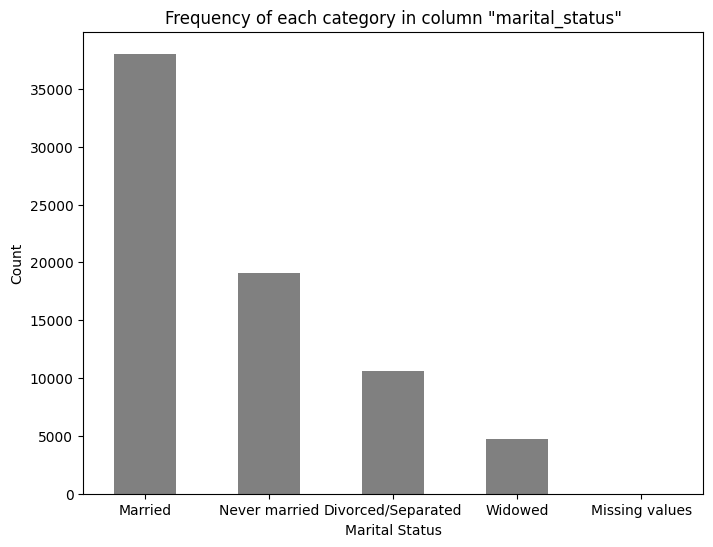

In [15]:
martital_status_counts = df['marital_status'].value_counts()
martital_status_counts['Missing values'] = df['marital_status'].isnull().sum()
print(martital_status_counts)
plt.figure(figsize=(8, 6)) 
martital_status_counts.plot(kind='bar',color=['gray'])
plt.title('Frequency of each category in column "marital_status"')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Marital_status, has no missing values and almost half of the dataset is married

## Health_ins

In [16]:
df['health_ins'].describe()

count     72458
unique        2
top        True
freq      65553
Name: health_ins, dtype: object

health_ins
True              65553
False              6905
Missing values        0
Name: count, dtype: int64


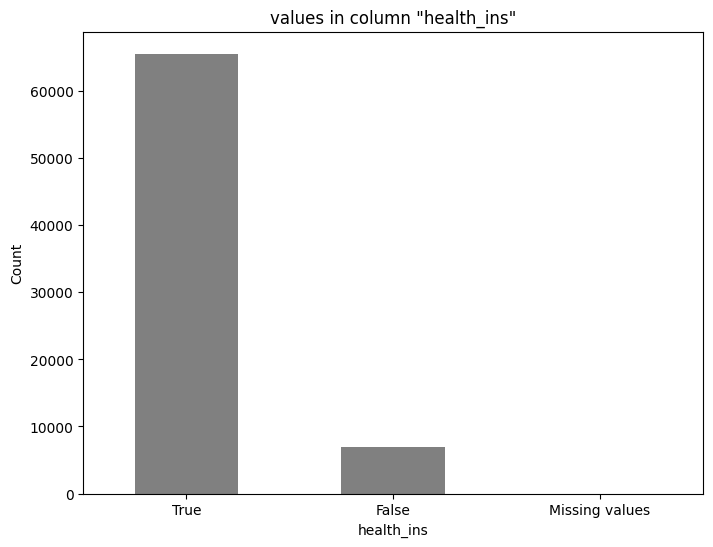

In [17]:
health_ins_counts = df['health_ins'].value_counts()
health_ins_counts['Missing values'] = df['health_ins'].isnull().sum()
print(health_ins_counts)
plt.figure(figsize=(8, 6)) 
health_ins_counts.plot(kind='bar',color=['gray'])
plt.title('values in column "health_ins"')
plt.xlabel('health_ins')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Health_ins, has no missing values and is extremely unbalanced... This can be a problem for the classification task

## Housing_type

housing_type
Homeowner with mortgage/loan    31092
Rented                          21956
Homeowner free and clear        16604
Occupied with no rent            1120
Missing values                   1686
Name: count, dtype: int64


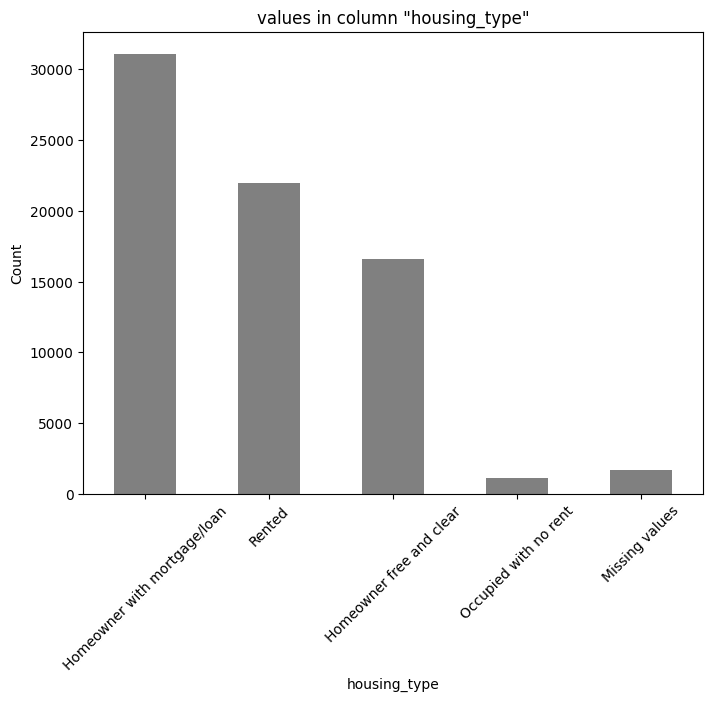

In [18]:
housing_type_counts = df['housing_type'].value_counts()
housing_type_counts['Missing values'] = df['housing_type'].isnull().sum()
print(housing_type_counts)
plt.figure(figsize=(8, 6)) 
housing_type_counts.plot(kind='bar',color=['gray'])
plt.title('values in column "housing_type"')
plt.xlabel('housing_type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Housing_type, has 1686 missing values

housing_type
Homeowner free and clear        59.326548
Homeowner with mortgage/loan    48.504052
Occupied with no rent           49.671429
Rented                          42.548552
Name: age, dtype: float64


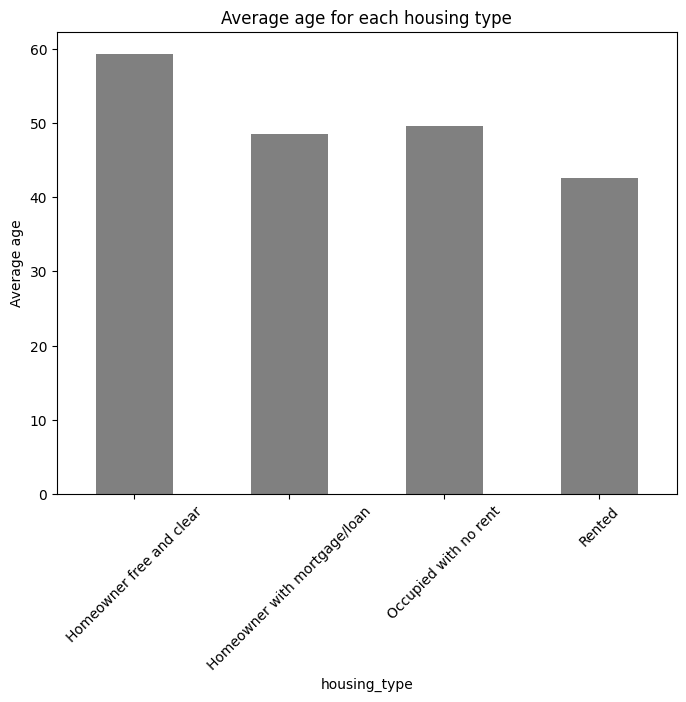

In [19]:
# Average age for each housing type
housing_type_age = df.groupby('housing_type')['age'].mean()
print(housing_type_age)
plt.figure(figsize=(8, 6))
housing_type_age.plot(kind='bar',color=['gray'])
plt.title('Average age for each housing type')
plt.xlabel('housing_type')
plt.ylabel('Average age')
plt.xticks(rotation=45)
plt.show()

## Num_vehicles

In [20]:
df['num_vehicles'].describe()

count    70772.000000
mean         2.066820
std          1.170076
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: num_vehicles, dtype: float64

num_vehicles
2.0               28052
1.0               17445
3.0               13094
4.0                5100
0.0                4636
5.0                1628
6.0                 817
Missing values     1686
Name: count, dtype: int64


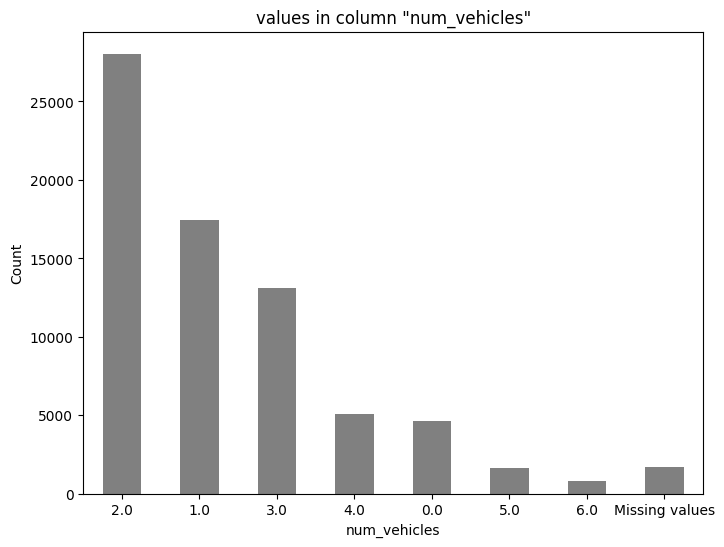

In [21]:
num_vehicles_counts = df['num_vehicles'].value_counts()
num_vehicles_counts['Missing values'] = df['num_vehicles'].isnull().sum()
print(num_vehicles_counts)
plt.figure(figsize=(8, 6)) 
num_vehicles_counts.plot(kind='bar',color=['gray'])
plt.title('values in column "num_vehicles"')
plt.xlabel('num_vehicles')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

num_vehicles, has 1686 missing values

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/1481514004.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_vehicles = df.groupby('age_group')['num_vehicles'].mean()


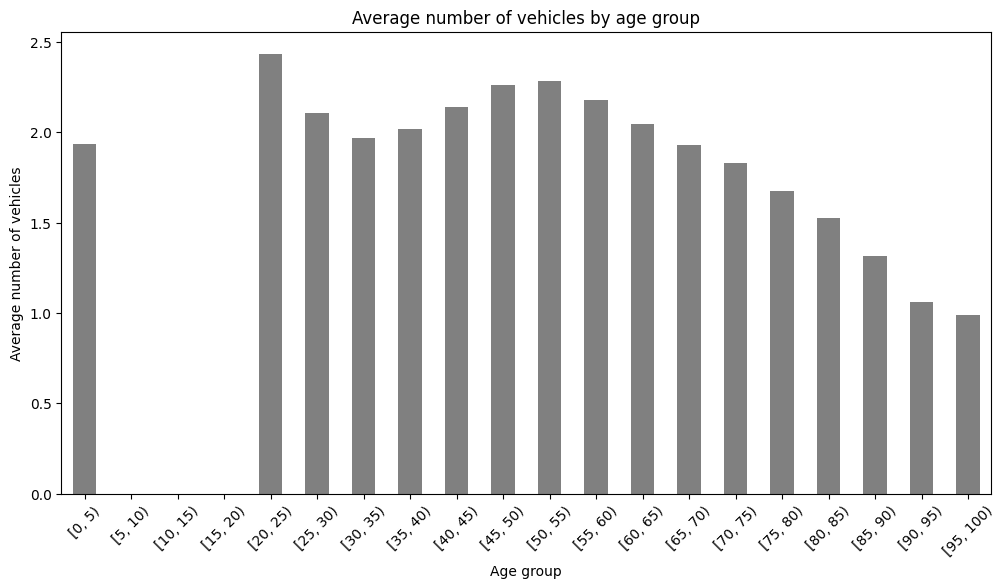

In [22]:
# Number of vehicles by age...
# group ages in 5 year intervals and calculate the average number of vehicles
df['age_group'] = pd.cut(df['age'], bins=range(0, 101, 5), right=False)
age_group_vehicles = df.groupby('age_group')['num_vehicles'].mean()
plt.figure(figsize=(12, 6))
age_group_vehicles.plot(kind='bar',color=['gray'])
plt.title('Average number of vehicles by age group')
plt.xlabel('Age group')
plt.ylabel('Average number of vehicles')
plt.xticks(rotation=45)
plt.show()

## Age

In [23]:
df['age'].describe()

count    72458.000000
mean        49.208893
std         18.090035
min          0.000000
25%         34.000000
50%         48.000000
75%         62.000000
max        120.000000
Name: age, dtype: float64

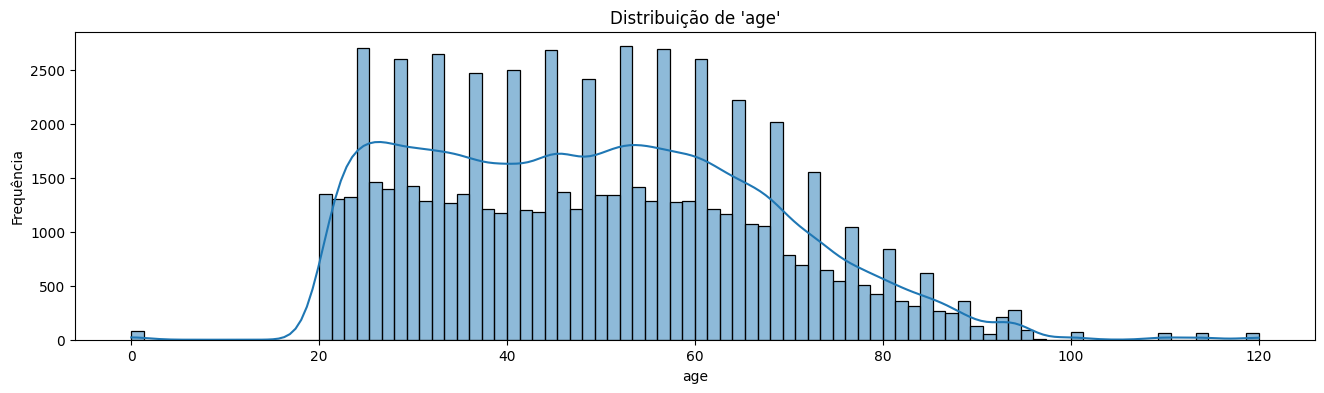

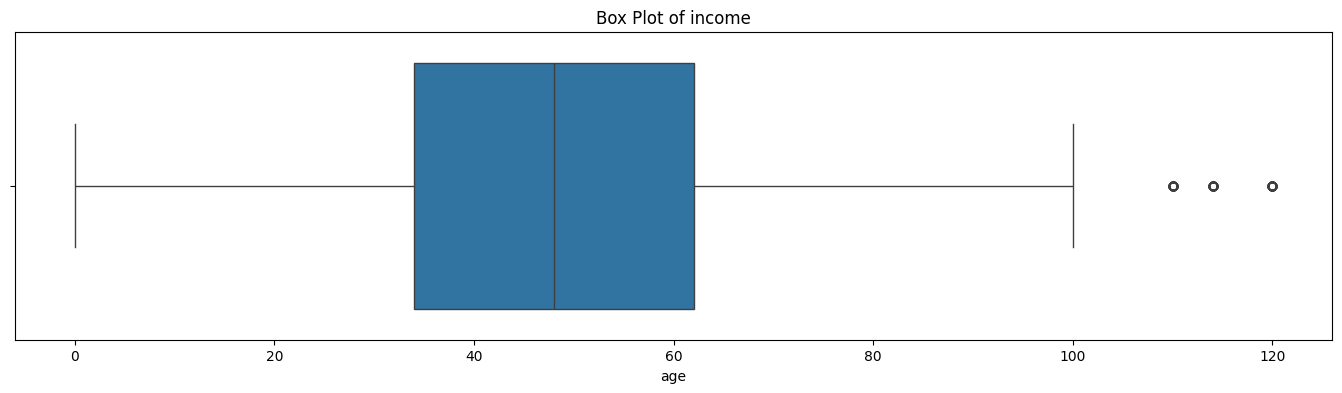

In [24]:
plt.figure(figsize=(16, 4))
sns.histplot(df['age'], kde=True)
plt.title("Distribuição de 'age'") 
plt.xlabel("age")
plt.ylabel("Frequência")
plt.show()

plt.figure(figsize=(17, 4))
sns.boxplot(x=df['age'])
plt.title(f'Box Plot of income')
plt.show()

Age has some atypical factors, not as serious as income.

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/3320793308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_age['age_group'] = pd.cut(df_filtered_age['age'], bins=range(20, 110, 10))


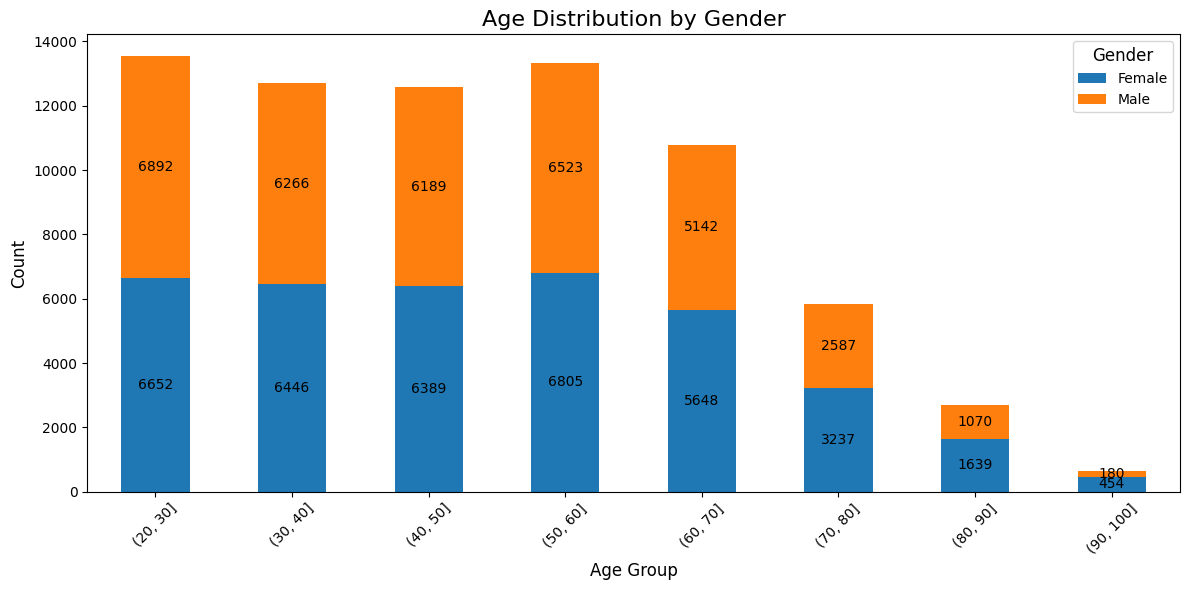

In [25]:
df_filtered_age = df[(df['age'] > 0) & (df['age'] < 100)]
df_filtered_age['age_group'] = pd.cut(df_filtered_age['age'], bins=range(20, 110, 10))
age_gender_counts = df_filtered_age.groupby(['age_group', 'sex'], observed=True).size().unstack()
ax = age_gender_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Age Distribution by Gender', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Gender', title_fontsize=12)
plt.xticks(rotation=45)

for c in ax.containers:
    ax.bar_label(c, label_type='center')

plt.tight_layout()
plt.show()

Genders seem well distributed across ages... but in older people, Females are more present. Does this corroborate with the fact that "Women live longer than men"?

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/2413142134.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=marital_age.index, y=marital_age.values, palette='viridis')


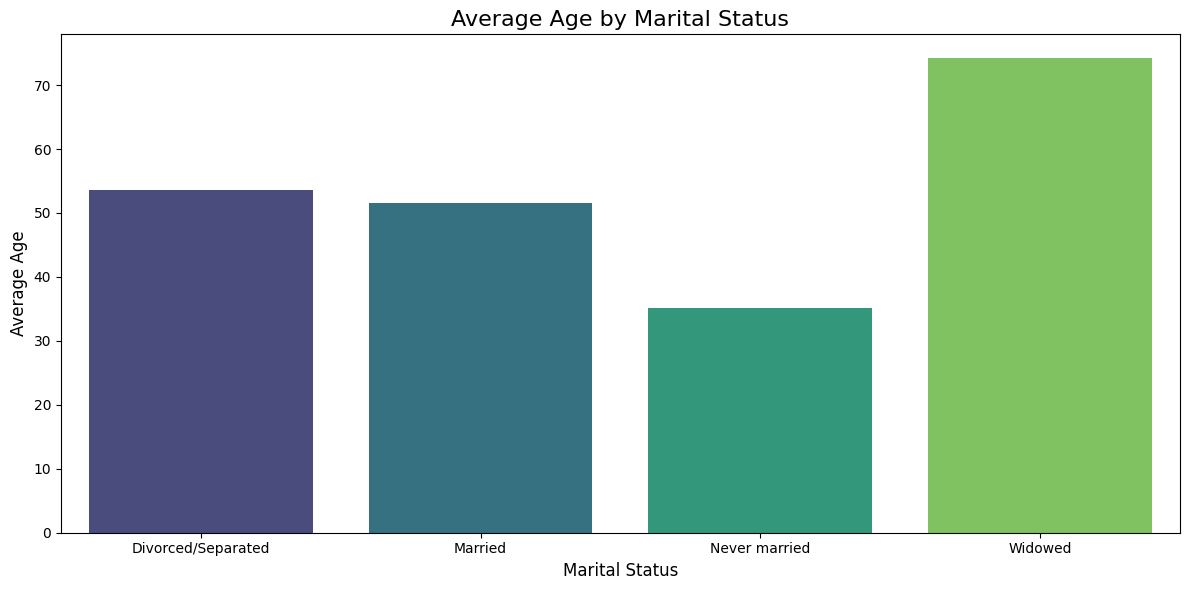

In [26]:
# Correlation between marital status and and age
marital_age = df_filtered_age.groupby('marital_status')['age'].mean()
plt.figure(figsize=(12, 6))
sns.barplot(x=marital_age.index, y=marital_age.values, palette='viridis')
plt.title('Average Age by Marital Status', fontsize=16)
plt.xlabel('Marital Status', fontsize=12)
plt.ylabel('Average Age', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Neevr married people are younger, while widowed people are older. Divorced people are slihghtly older than married people.
These insights seem to be consistent with the real world.

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/2758096716.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_age['age_group'] = pd.cut(df_filtered_age['age'], bins=range(20, 110, 5))
/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/2758096716.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_income = df_filtered_age.groupby('age_group')['income'].mean()
/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/2758096716.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated 

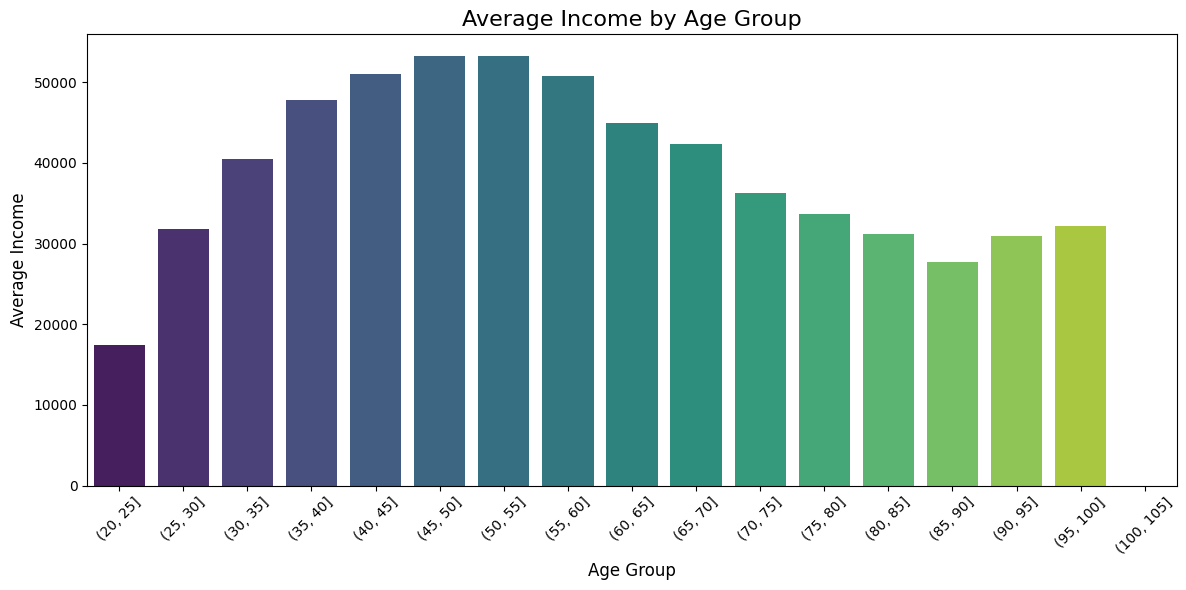

In [27]:
# How does age affect income?
# group ages in bins of 5 and calculate the average income for each group
df_filtered_age['age_group'] = pd.cut(df_filtered_age['age'], bins=range(20, 110, 5))
age_income = df_filtered_age.groupby('age_group')['income'].mean()

#Now i want a bar plor with age in x axis and income in y axis
plt.figure(figsize=(12, 6))
sns.barplot(x=age_income.index, y=age_income.values, palette='viridis')
plt.title('Average Income by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Average Income', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

## Gas_usage

In [28]:
df['gas_usage'].describe()

count    70772.000000
mean        41.230501
std         63.149323
min          1.000000
25%          3.000000
50%         10.000000
75%         60.000000
max        570.000000
Name: gas_usage, dtype: float64

Number of NaN in gas_usage : 1686


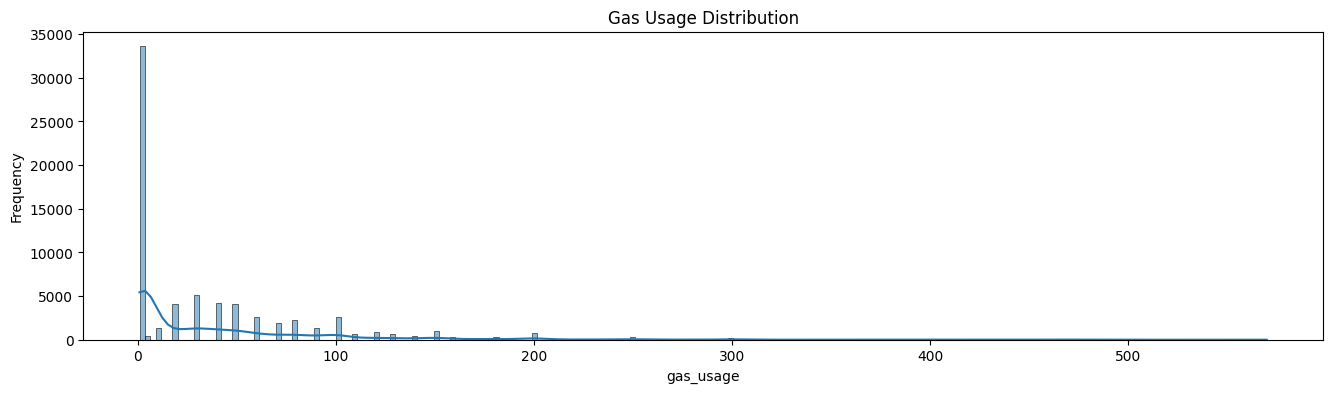

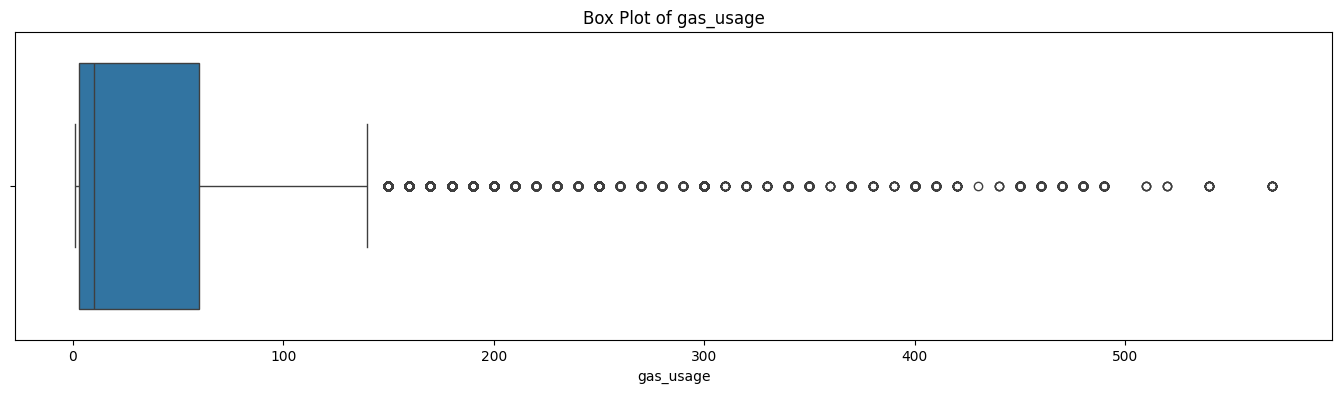

In [29]:
print(f"Number of NaN in gas_usage : {df['gas_usage'].isnull().sum()}")

plt.figure(figsize=(16, 4))
sns.histplot(df['gas_usage'], kde=True)
plt.title("Gas Usage Distribution")
plt.xlabel("gas_usage")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(17, 4))
sns.boxplot(x=df['gas_usage'])
plt.title(f'Box Plot of gas_usage')
plt.show()

Gas usage also have outliers and have 1686 missing values too

## Rooms

rooms
2                 12230
3                 12134
5                 12098
1                 12042
6                 11999
4                 11955
Missing values        0
Name: count, dtype: int64


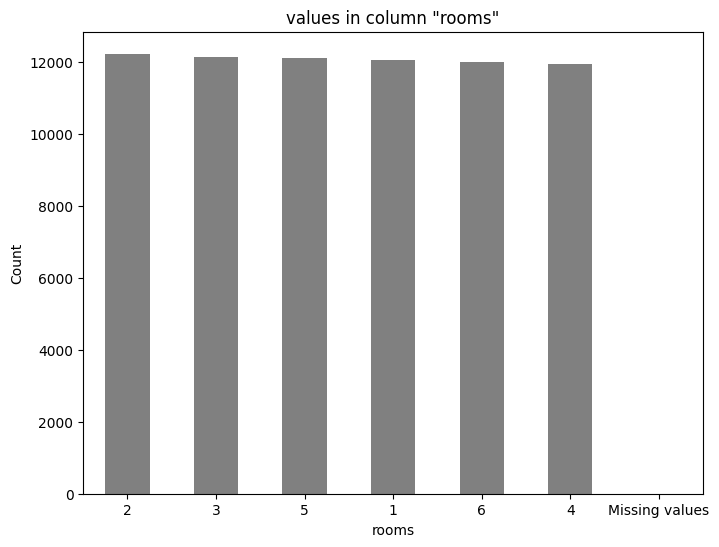

In [30]:
rooms_counts = df['rooms'].value_counts()
rooms_counts['Missing values'] = df['rooms'].isnull().sum()
print(rooms_counts)
plt.figure(figsize=(8, 6)) 
rooms_counts.plot(kind='bar',color=['gray'])
plt.title('values in column "rooms"')
plt.xlabel('rooms')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Rooms, have a ballanced distribution without any missing value

## Recent_move_b

recent_move_b
F                 61773
T                  8998
Missing values     1687
Name: count, dtype: int64


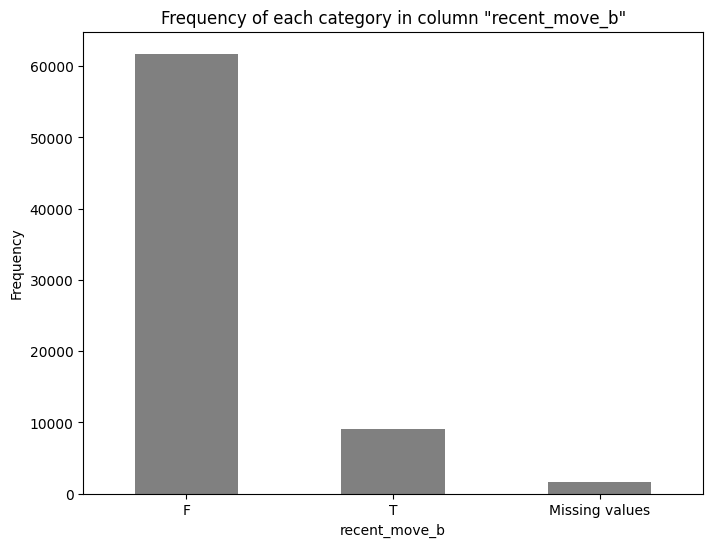

In [31]:
recent_move_b_counts = df['recent_move_b'].value_counts()
recent_move_b_counts['Missing values'] = df['recent_move_b'].isnull().sum()
print(recent_move_b_counts)
plt.figure(figsize=(8, 6)) 
recent_move_b_counts.plot(kind='bar',color=['gray'])
plt.title('Frequency of each category in column "recent_move_b"')
plt.xlabel('recent_move_b')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

recent_move_b have 1687 missing values and its unballanced

In [32]:
# States with most recent moves. Filter for recent moves = True
recent_moves = df[df['recent_move_b'] == 'T']
recent_moves['state_of_res'].value_counts().head(5)

state_of_res
California    1001
Texas          885
Florida        661
New York       380
Illinois       345
Name: count, dtype: int64

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/2605464244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_moves['age_group'] = pd.cut(recent_moves['age'], bins=range(20, 110, 10))
/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/2605464244.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_recent_moves = recent_moves.groupby('age_group').size()
/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/2605464244.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be 

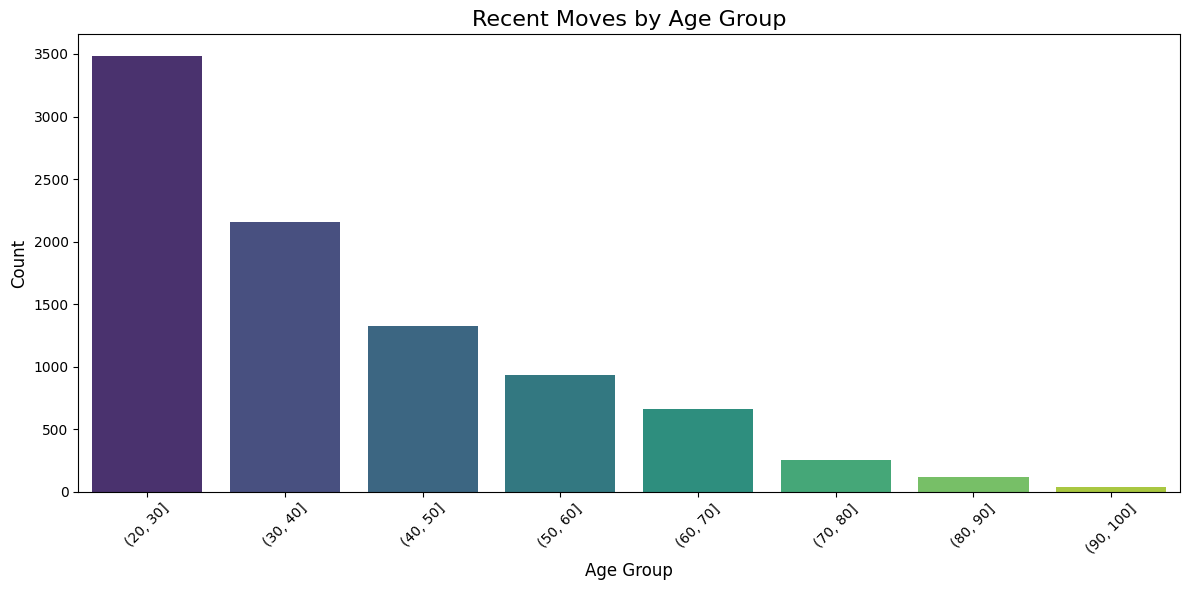

In [33]:
# What age do people move the most?
recent_moves['age_group'] = pd.cut(recent_moves['age'], bins=range(20, 110, 10))
age_recent_moves = recent_moves.groupby('age_group').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=age_recent_moves.index, y=age_recent_moves.values, palette='viridis')

plt.title('Recent Moves by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Younger people tend to having moved recently more than older people.

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/381469379.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=housing_recent_moves.index, y=housing_recent_moves.values, palette='viridis')


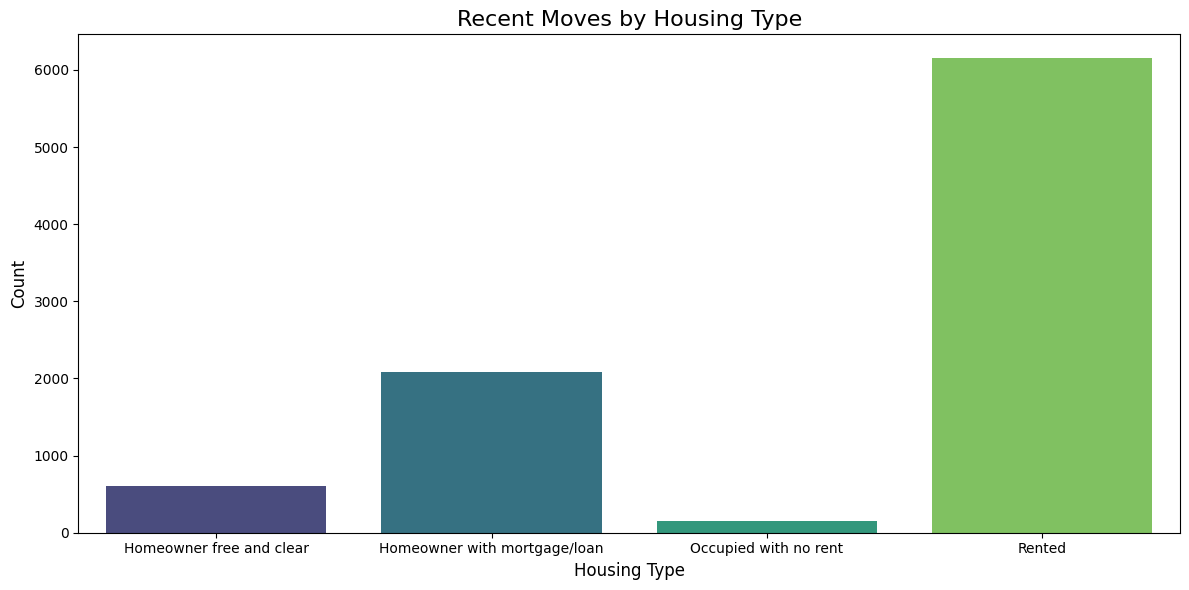

In [34]:
# Correlation between housing type and recent moves

housing_recent_moves = recent_moves.groupby(['housing_type']).size()
plt.figure(figsize=(12, 6))
sns.barplot(x=housing_recent_moves.index, y=housing_recent_moves.values, palette='viridis')
plt.title('Recent Moves by Housing Type', fontsize=16)
plt.xlabel('Housing Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

People who have moved recently tend to be in a rented house.

## State_of_res

In [35]:
df['state_of_res'].describe()

count          72458
unique            51
top       California
freq            8870
Name: state_of_res, dtype: object

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/136571102.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')


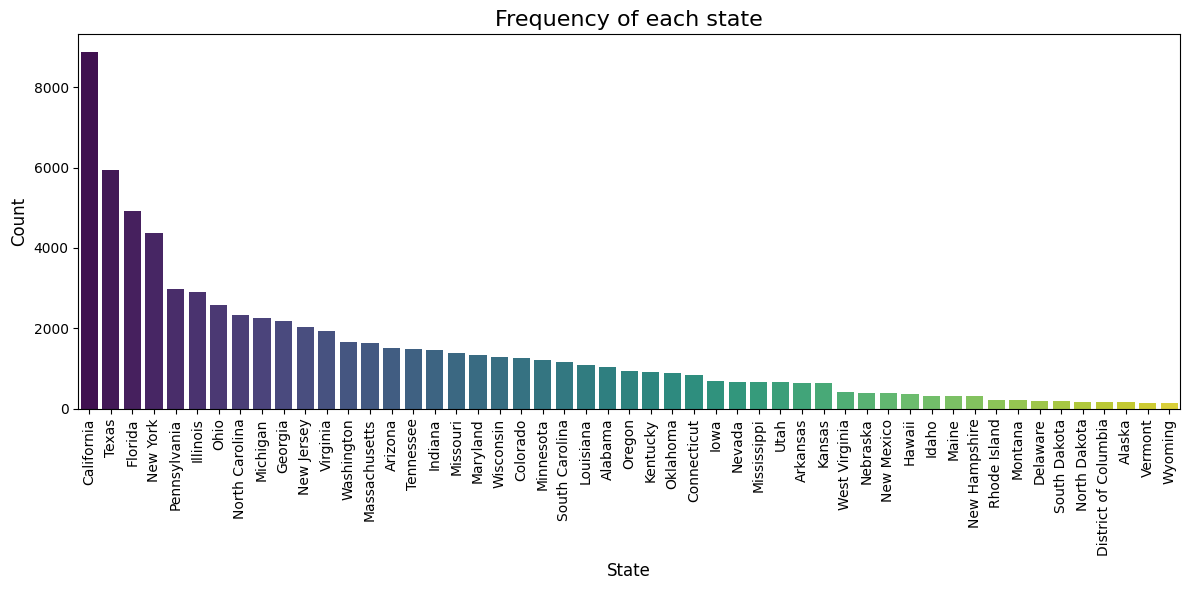

In [36]:
# plot frequency of each state
state_counts = df['state_of_res'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')
plt.title('Frequency of each state', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/4017914817.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_age.index, y=state_age.values, palette='viridis')


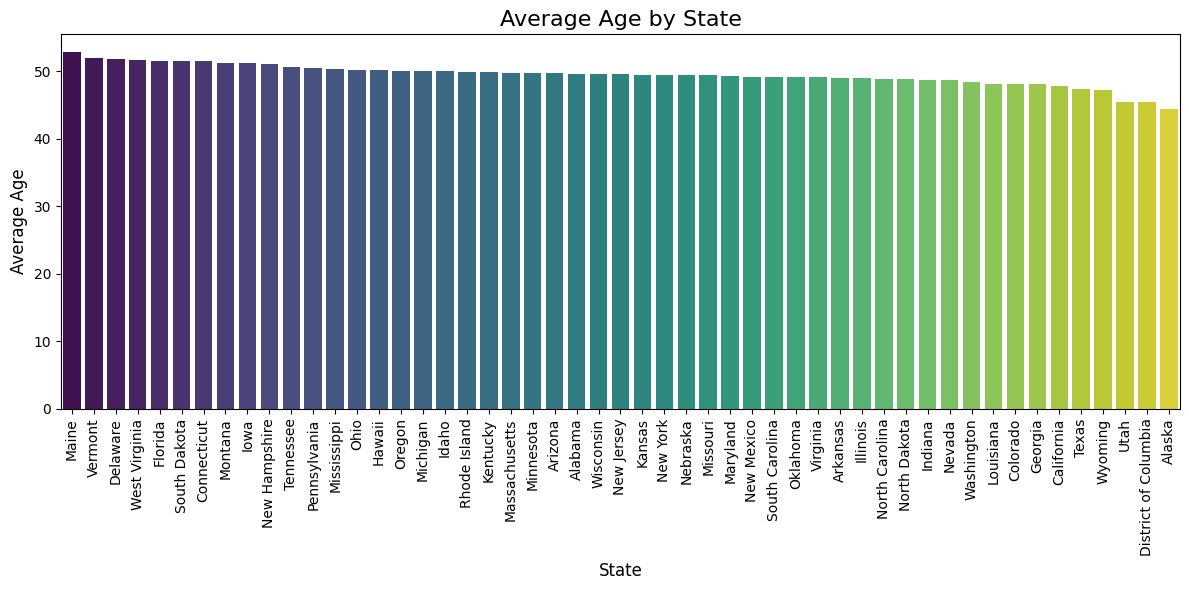

In [37]:
# mean age for each state
state_age = df.groupby('state_of_res')['age'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=state_age.index, y=state_age.values, palette='viridis')
plt.title('Average Age by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Average Age', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_36928/1596732343.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_income.index, y=state_income.values, palette='viridis')


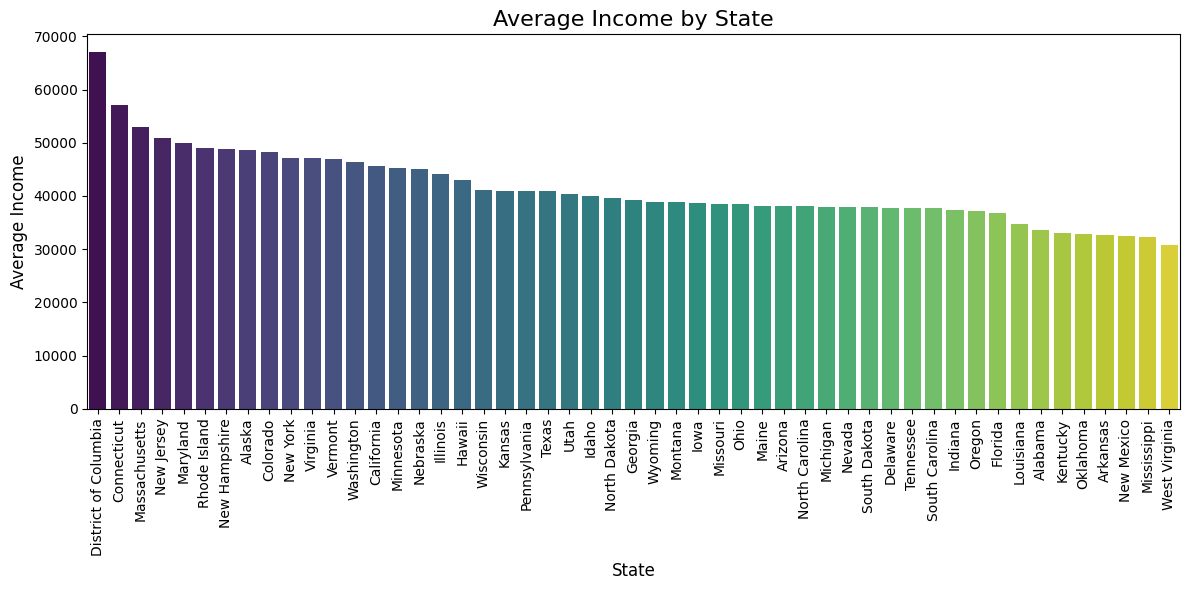

In [38]:
# Mean income for each state
state_income = df.groupby('state_of_res')['income'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=state_income.index, y=state_income.values, palette='viridis')
plt.title('Average Income by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Average Income', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Preprocessing of training data

This section will be dedicated to the preprocessing of the training dataset. 
The objective is to create a new dataset with good characteristics for, in future sections, be used to train some machine learning models.

We will consider the main insights from the EDA section to guide the preprocessing steps.
The following tasks will be performed:
- Treat missing values
- Remove unnecessary columns
- Deal with outliers
- Scale numerical features (considering Standard Scaling and Min-Max Scaling)
- Encode categorical features (considering Label Encoding and One-Hot Encoding)

In [72]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [73]:
# Load the original dataset
df = pd.read_csv('../data/customer.csv')
print(df.shape)
print(df.columns)

(72458, 15)
Index(['Unnamed: 0', 'custid', 'sex', 'is_employed', 'income',
       'marital_status', 'health_ins', 'housing_type', 'num_vehicles', 'age',
       'state_of_res', 'code_column', 'gas_usage', 'rooms', 'recent_move_b'],
      dtype='object')


In [74]:
# Check the frequency of categories in the 'is_employed' column
df['is_employed'].value_counts(dropna=False)

is_employed
True     44630
NaN      25515
False     2313
Name: count, dtype: int64

In [75]:
# people with missing values in 'is_employed' will be considered as unemployed
df['is_employed'] = df['is_employed'].fillna(False)
df['is_employed'].value_counts()

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_81565/1844132814.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_employed'] = df['is_employed'].fillna(False)


is_employed
True     44630
False    27828
Name: count, dtype: int64

In [76]:
# Maximum and Minimum number of code_column associated with a state_of_res
max(df.groupby('state_of_res')['code_column'].nunique()), min(df.groupby('state_of_res')['code_column'].nunique())

(1, 1)

In [77]:
# Since each state has 1 code, we can drop the 'code_column' feature.
# We can also drop the idetifier columns 'Unnamed: 0' and 'custid'
# 'recent_move_b' is an irrelevant feature, we can drop it as well
df.drop(['Unnamed: 0','custid','code_column','recent_move_b'], axis=1, inplace=True)
print(df.shape)
print(df.columns)

(72458, 11)
Index(['sex', 'is_employed', 'income', 'marital_status', 'health_ins',
       'housing_type', 'num_vehicles', 'age', 'state_of_res', 'gas_usage',
       'rooms'],
      dtype='object')


In [78]:
df.isnull().sum()

sex                  0
is_employed          0
income               0
marital_status       0
health_ins           0
housing_type      1686
num_vehicles      1686
age                  0
state_of_res         0
gas_usage         1686
rooms                0
dtype: int64

In [79]:
num = df[df.isnull().any(axis=1)].shape[0]
print(print(f'{num} rows have missing values. \nApprox. {num/df.shape[0]*100:.2f}% of the orignal dataset.'))

1686 rows have missing values. 
Approx. 2.33% of the orignal dataset.
None


```python
# Missing values are all in the same rows. We can drop them
df.dropna(inplace=True)
df.shape
````

In [80]:
# Instead of dropping the rows with missing values, we can use imputation techniques
# For numerical features, we can use the median
# For categorical features, we can use the mode
df['housing_type'].fillna(df['housing_type'].mode()[0], inplace=True)
df['num_vehicles'].fillna(df['num_vehicles'].median(), inplace=True)
df['gas_usage'].fillna(df['gas_usage'].median(), inplace=True)

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_81565/1727040877.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['housing_type'].fillna(df['housing_type'].mode()[0], inplace=True)
/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_81565/1727040877.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [81]:
df[df['age'] < 21]['age'].value_counts()

age
0    77
Name: count, dtype: int64

In [82]:
df[df['age'] < 21]

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms
594,Male,True,50000.0,Never married,False,Rented,1.0,0,Alabama,3.0,3
1260,Male,False,0.0,Married,True,Rented,0.0,0,Arizona,3.0,4
1658,Female,True,24700.0,Never married,True,Rented,3.0,0,Arizona,3.0,5
2340,Female,True,2400.0,Divorced/Separated,True,Rented,0.0,0,Arizona,3.0,4
2859,Female,False,9700.0,Married,True,Homeowner free and clear,3.0,0,Arkansas,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...
67967,Female,False,5000.0,Widowed,True,Homeowner with mortgage/loan,0.0,0,Virginia,3.0,2
68681,Female,True,80000.0,Married,True,Homeowner with mortgage/loan,2.0,0,Virginia,90.0,3
69200,Male,False,0.0,Never married,True,Rented,2.0,0,Washington,3.0,6
70015,Male,True,75000.0,Divorced/Separated,True,Homeowner free and clear,2.0,0,Washington,3.0,4


In [83]:
# For variable 'age', we will truncate values to 21-99. 
# Values outside this range will be replaced to th closest endpoint.
print(f'Max age: {df['age'].max()} | Min age: {df['age'].min()}')
df['age'] = df['age'].clip(lower=21, upper=99)
print(f'Max age: {df['age'].max()} | Min age: {df['age'].min()}')
print(df.shape)

Max age: 120 | Min age: 0
Max age: 99 | Min age: 21
(72458, 11)


In [84]:
# Columns to be scaled to min-max range: 'age', 'num_vehicles', 'rooms'
min_max_columns = ['age', 'num_vehicles', 'rooms']
scaler = MinMaxScaler()
# Round the scaled values to 2 decimal places, to group similar values
df[min_max_columns] = scaler.fit_transform(df[min_max_columns]).round(2)
df[min_max_columns].describe()

,age,num_vehicles,rooms
count,72458.000000,72458.000000,72458.000000
mean,0.361449,0.343805,0.498910
std,0.229563,0.192299,0.341307
min,0.000000,0.000000,0.000000
25%,0.170000,0.170000,0.200000
50%,0.350000,0.330000,0.400000
75%,0.530000,0.500000,0.800000
max,1.000000,1.000000,1.000000


In [85]:
df['income'].describe()

count    7.245800e+04
mean     4.188143e+04
std      5.827460e+04
min     -6.900000e+03
25%      1.070000e+04
50%      2.640000e+04
75%      5.200000e+04
max      1.257000e+06
Name: income, dtype: float64

In [86]:
# Negative values in 'income' will be replaced by their absolute values
df['income'] = df['income'].abs()
df['income'].describe()

count    7.245800e+04
mean     4.188688e+04
std      5.827069e+04
min      0.000000e+00
25%      1.070000e+04
50%      2.640000e+04
75%      5.200000e+04
max      1.257000e+06
Name: income, dtype: float64

In [87]:
# Columns to be scaled to standard normal distribution: 'income', 'gas_usage'
standard_columns = ['income', 'gas_usage']
scaler = StandardScaler()
df[standard_columns] = scaler.fit_transform(df[['income', 'gas_usage']]).round(2)
df[standard_columns].describe()

,income,gas_usage
count,72458.000000,72458.000000
mean,-0.000074,-0.001335
std,1.000088,1.000588
min,-0.720000,-0.630000
25%,-0.540000,-0.600000
50%,-0.270000,-0.490000
75%,0.170000,0.150000
max,20.850000,8.460000


In [88]:
df.head(10)

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms
0,Male,True,-0.34,Never married,True,Homeowner free and clear,0.00,0.04,Alabama,2.71,0.4
1,Female,False,-0.32,Divorced/Separated,True,Rented,0.00,0.78,Alabama,-0.60,1.0
2,Female,True,-0.36,Never married,True,Homeowner with mortgage/loan,0.33,0.13,Alabama,-0.01,0.4
3,Female,False,-0.07,Widowed,True,Homeowner free and clear,0.17,0.92,Alabama,1.27,0.2
4,Male,True,-0.05,Divorced/Separated,True,Rented,0.33,0.59,Alabama,-0.60,0.2
5,Male,False,-0.53,Married,True,Homeowner free and clear,0.33,0.71,Alabama,2.55,1.0
6,Female,True,-0.28,Married,False,Rented,0.33,0.06,Alabama,-0.60,0.4
7,Female,False,-0.13,Married,True,Homeowner free and clear,0.33,0.67,Alabama,0.15,0.8
8,Female,True,-0.29,Never married,True,Homeowner free and clear,0.83,0.08,Alabama,-0.60,0.6
9,Male,True,-0.18,Married,True,Homeowner with mortgage/loan,0.50,0.42,Alabama,-0.33,1.0


- sex - categorical nominal (binary)
- is_emplyed - categorical nominal (binary)
- income - numerical
- marital_status - categorical nominal (multiclass)
- health_ins - categorical nominal (binary)
- housing_type - categorical nominal (multiclass)
- num_vehicles - numerical
- age - numerical
- state_of_residence - categorical nominal (multiclass)
- gas_usage - numerical
- rooms - numerical

In [89]:
cols_label_encode = ['sex','is_employed','health_ins', 'state_of_res']
cols_one_hot_encode = ['marital_status', 'housing_type']

In [90]:
label_encoder = LabelEncoder()
for col in cols_label_encode:
    df[col] = label_encoder.fit_transform(df[col])

In [91]:
df = pd.get_dummies(df, columns=cols_one_hot_encode)
df.head()

,sex,is_employed,income,health_ins,num_vehicles,age,state_of_res,gas_usage,rooms,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented
0,1,1,-0.34,1,0.00,0.04,0,2.71,0.4,False,False,True,False,True,False,False,False
1,0,0,-0.32,1,0.00,0.78,0,-0.60,1.0,True,False,False,False,False,False,False,True
2,0,1,-0.36,1,0.33,0.13,0,-0.01,0.4,False,False,True,False,False,True,False,False
3,0,0,-0.07,1,0.17,0.92,0,1.27,0.2,False,False,False,True,True,False,False,False
4,1,1,-0.05,1,0.33,0.59,0,-0.60,0.2,True,False,False,False,False,False,False,True


In [92]:
dummies = list(filter(lambda x: x.startswith(tuple(cols_one_hot_encode)), df.columns))
dummies

['marital_status_Divorced/Separated',
 'marital_status_Married',
 'marital_status_Never married',
 'marital_status_Widowed',
 'housing_type_Homeowner free and clear',
 'housing_type_Homeowner with mortgage/loan',
 'housing_type_Occupied with no rent',
 'housing_type_Rented']

In [93]:
for col in dummies:
    df[col] = label_encoder.fit_transform(df[col])

df.head()

,sex,is_employed,income,health_ins,num_vehicles,age,state_of_res,gas_usage,rooms,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented
0,1,1,-0.34,1,0.00,0.04,0,2.71,0.4,0,0,1,0,1,0,0,0
1,0,0,-0.32,1,0.00,0.78,0,-0.60,1.0,1,0,0,0,0,0,0,1
2,0,1,-0.36,1,0.33,0.13,0,-0.01,0.4,0,0,1,0,0,1,0,0
3,0,0,-0.07,1,0.17,0.92,0,1.27,0.2,0,0,0,1,1,0,0,0
4,1,1,-0.05,1,0.33,0.59,0,-0.60,0.2,1,0,0,0,0,0,0,1


In [94]:
# Min-max scale the 'state_of_res' column
df['state_of_res'] = MinMaxScaler().fit_transform(df[['state_of_res']])
df['state_of_res'].describe()

count    72458.000000
mean         0.474746
std          0.302055
min          0.000000
25%          0.180000
50%          0.460000
75%          0.760000
max          1.000000
Name: state_of_res, dtype: float64

In [95]:
# save the cleaned data to a new csv file
df.to_csv('../data/customer_cleaned.csv', index=False)

The cleaned dataset is saved in a new file: `customer_cleaned.csv`. This file can be used in future sections to load the cleaned dataset and train some models.

In this section, we conducted the following approaches:
- missing values in `is_employed` were filled with `False`
- columns `Unnamed: 0`, `custid`, `code_column`, `recent_move_b` were removed
- `age` values were truncateed to [21, 99]
- columns `age`, `num_vehicles`, `rooms` were scaled using Min-Max Scaling
- columns `income` and `gas_usage` were scaled using Standard Scaling
- categorical columns were encoded using One-Hot Encoding or Label Encoding, according to the nature of their categories

# Model Experimentation

In this section, we will experiment, for the first time, some classification models on the `customer_cleaned` dataset. 

In order to have a simple baseline, we will employ simple models that are easy to interpret and understand. The models we will experiment with are:
- Decision Tree
- Random Forest
- K-Nearest Neighbors

The objective of this section is to get a sense of how the models perform on the dataset to identify potential candidates for further optimization, or find a problem with the data that needs to be addressed before proceeding.

We will also perform some hyperparameter tuning on the models to see how their performance can be improved with some optimization.

In order to get some performance metrics, we will divide the training data into a training and validation sets (70% - 30%), and use the valdation set to evaluate the models.

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [96]:
# Load the treated dataset
df = pd.read_csv('../data/customer_cleaned.csv')
df.shape

(72458, 17)

In [97]:
df.head(10)

,sex,is_employed,income,health_ins,num_vehicles,age,state_of_res,gas_usage,rooms,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented
0,1,1,-0.34,1,0.00,0.04,0.0,2.71,0.4,0,0,1,0,1,0,0,0
1,0,0,-0.32,1,0.00,0.78,0.0,-0.60,1.0,1,0,0,0,0,0,0,1
2,0,1,-0.36,1,0.33,0.13,0.0,-0.01,0.4,0,0,1,0,0,1,0,0
3,0,0,-0.07,1,0.17,0.92,0.0,1.27,0.2,0,0,0,1,1,0,0,0
4,1,1,-0.05,1,0.33,0.59,0.0,-0.60,0.2,1,0,0,0,0,0,0,1
5,1,0,-0.53,1,0.33,0.71,0.0,2.55,1.0,0,1,0,0,1,0,0,0
6,0,1,-0.28,0,0.33,0.06,0.0,-0.60,0.4,0,1,0,0,0,0,0,1
7,0,0,-0.12,1,0.33,0.67,0.0,0.15,0.8,0,1,0,0,1,0,0,0
8,0,1,-0.29,1,0.83,0.08,0.0,-0.60,0.6,0,0,1,0,1,0,0,0
9,1,1,-0.18,1,0.50,0.42,0.0,-0.33,1.0,0,1,0,0,0,1,0,0


In [98]:
# Splitting the columns into features and target
X = df.drop(['health_ins'], axis=1)
y = df['health_ins']

X.shape

(72458, 16)

In [99]:
# Divide the data into training and test sets (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [100]:
# Functio to rexeive results of a model and plot its evolution for a given parameter
def plot_measures(measures):
    parameters = measures.iloc[:,0]
    accuracy = measures.iloc[:,1]
    precision = measures.iloc[:,2]
    recall = measures.iloc[:,3]
    f1 = measures.iloc[:,4]
    spec = measures.iloc[:,5]

    sns.lineplot(x=parameters, y=accuracy, label='accuracy')
    sns.lineplot(x=parameters, y=precision, label='precision')
    sns.lineplot(x=parameters, y=recall, label='recall')
    sns.lineplot(x=parameters, y=f1, label='f1')
    sns.lineplot(x=parameters, y=spec, label='specificity')

In [101]:
# Function to, given the prediction of a model, return its: accuracy, precision, recall, f1 and confusion matrix
def get_metrics(y_pred):
    acc = round(accuracy_score(y_test, y_pred),3)
    prec = round(precision_score(y_test, y_pred),3)
    rec = round(recall_score(y_test, y_pred),3)
    f1 = round(f1_score(y_test, y_pred),3)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    spec = round(tn / (tn+fp),3)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'specificity': spec, 'cm': cm}

In [102]:
# Dataframe to store the results of the models
models = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])

## Decision Trees

Fitting model with 1
Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with None


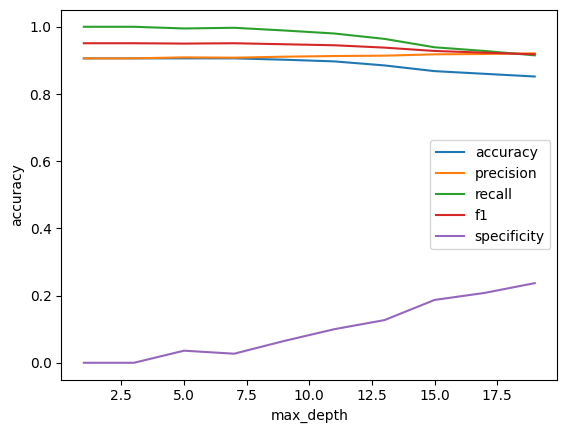

In [103]:
dec_tree_measures = pd.DataFrame(columns=['max_depth', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(1, 20, 2)) + [None]

for max_depth in parameters:
    print(f'Fitting model with {max_depth}')
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'max_depth': max_depth, **measures}
    dec_tree_measures.loc[len(dec_tree_measures)] = new_row


plot_measures(dec_tree_measures)

In [104]:
row = dec_tree_measures[dec_tree_measures['max_depth'] == 7]
models.loc[len(models)] = {'model': 'Decision Tree', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.906,0.908,0.997,0.951,0.027,"[[55, 1981], [53, 19649]]"


## Random Forest

Fitting model with 10
Fitting model with 20
Fitting model with 50
Fitting model with 75
Fitting model with 100
Fitting model with 200
Fitting model with 500


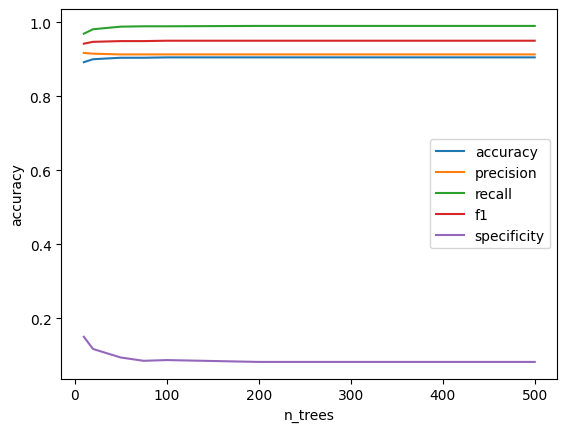

In [105]:
rf_measures = pd.DataFrame(columns=['n_trees', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = [10, 20, 50, 75, 100, 200, 500]

for n_trees in parameters:
    print(f'Fitting model with {n_trees}')
    model = RandomForestClassifier(n_estimators=n_trees)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_trees': n_trees, **measures}
    rf_measures.loc[len(rf_measures)] = new_row

plot_measures(rf_measures)

In [106]:
row = rf_measures[rf_measures['n_trees'] == 100]
models.loc[len(models)] = {'model': 'Random Forest', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.906,0.908,0.997,0.951,0.027,"[[55, 1981], [53, 19649]]"
1,Random Forest,0.905,0.913,0.989,0.950,0.087,"[[178, 1858], [210, 19492]]"


## K Nearest Neighbors

Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with 21
Fitting model with 23


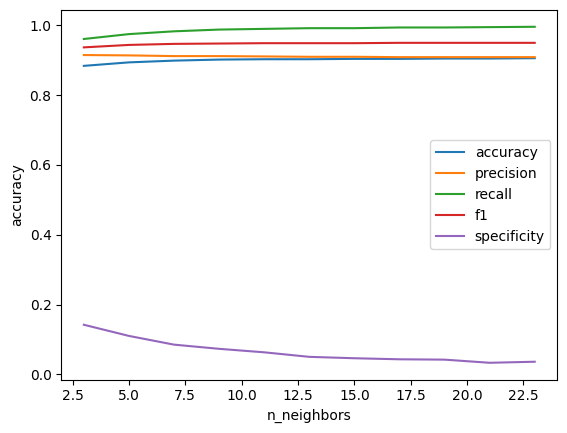

In [107]:
knn_measures = pd.DataFrame(columns=['n_neighbors', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(3, 25, 2))

for n_neighbors in parameters:
    print(f'Fitting model with {n_neighbors}')
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_neighbors': n_neighbors, **measures}
    knn_measures.loc[len(knn_measures)] = new_row

plot_measures(knn_measures)

In [108]:
row = knn_measures[knn_measures['n_neighbors'] == 11]
models.loc[len(models)] = {'model': 'KNN', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.906,0.908,0.997,0.951,0.027,"[[55, 1981], [53, 19649]]"
1,Random Forest,0.905,0.913,0.989,0.950,0.087,"[[178, 1858], [210, 19492]]"
2,KNN,0.903,0.911,0.990,0.949,0.063,"[[128, 1908], [199, 19503]]"


## Overall comparison of the models

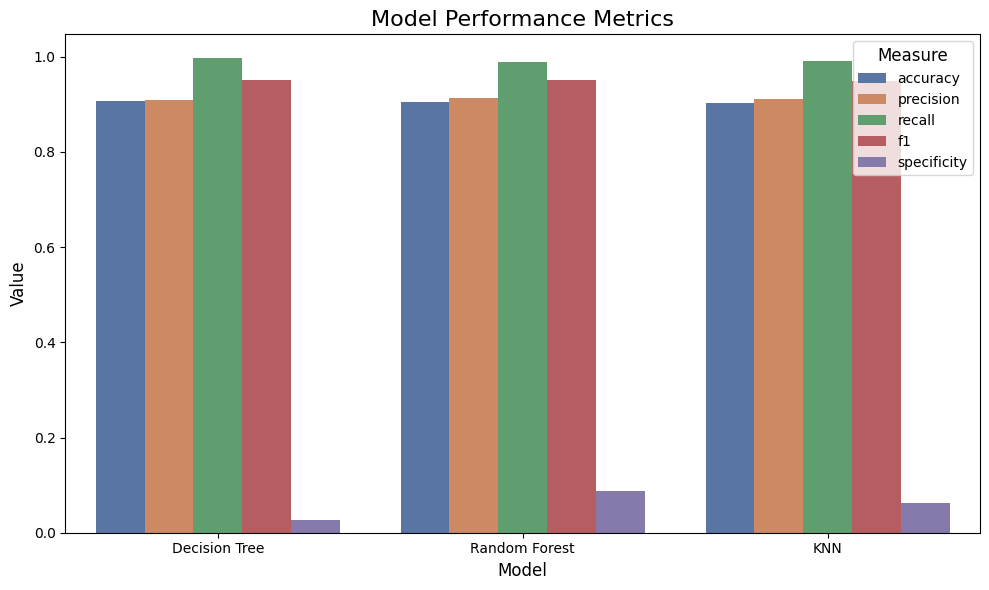

In [109]:
melted = models.melt(id_vars="model", value_vars=["accuracy", "precision", "recall", "f1", "specificity"],
                     var_name="measure", value_name="value")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="model", y="value", hue="measure", palette="deep")

plt.title("Model Performance Metrics", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Measure", fontsize=10, title_fontsize=12)
plt.tight_layout()

plt.show()

In [110]:
conf_mxs = models[['model', 'cm']]
conf_mxs

,model,cm
0,Decision Tree,"[[55, 1981], [53, 19649]]"
1,Random Forest,"[[178, 1858], [210, 19492]]"
2,KNN,"[[128, 1908], [199, 19503]]"


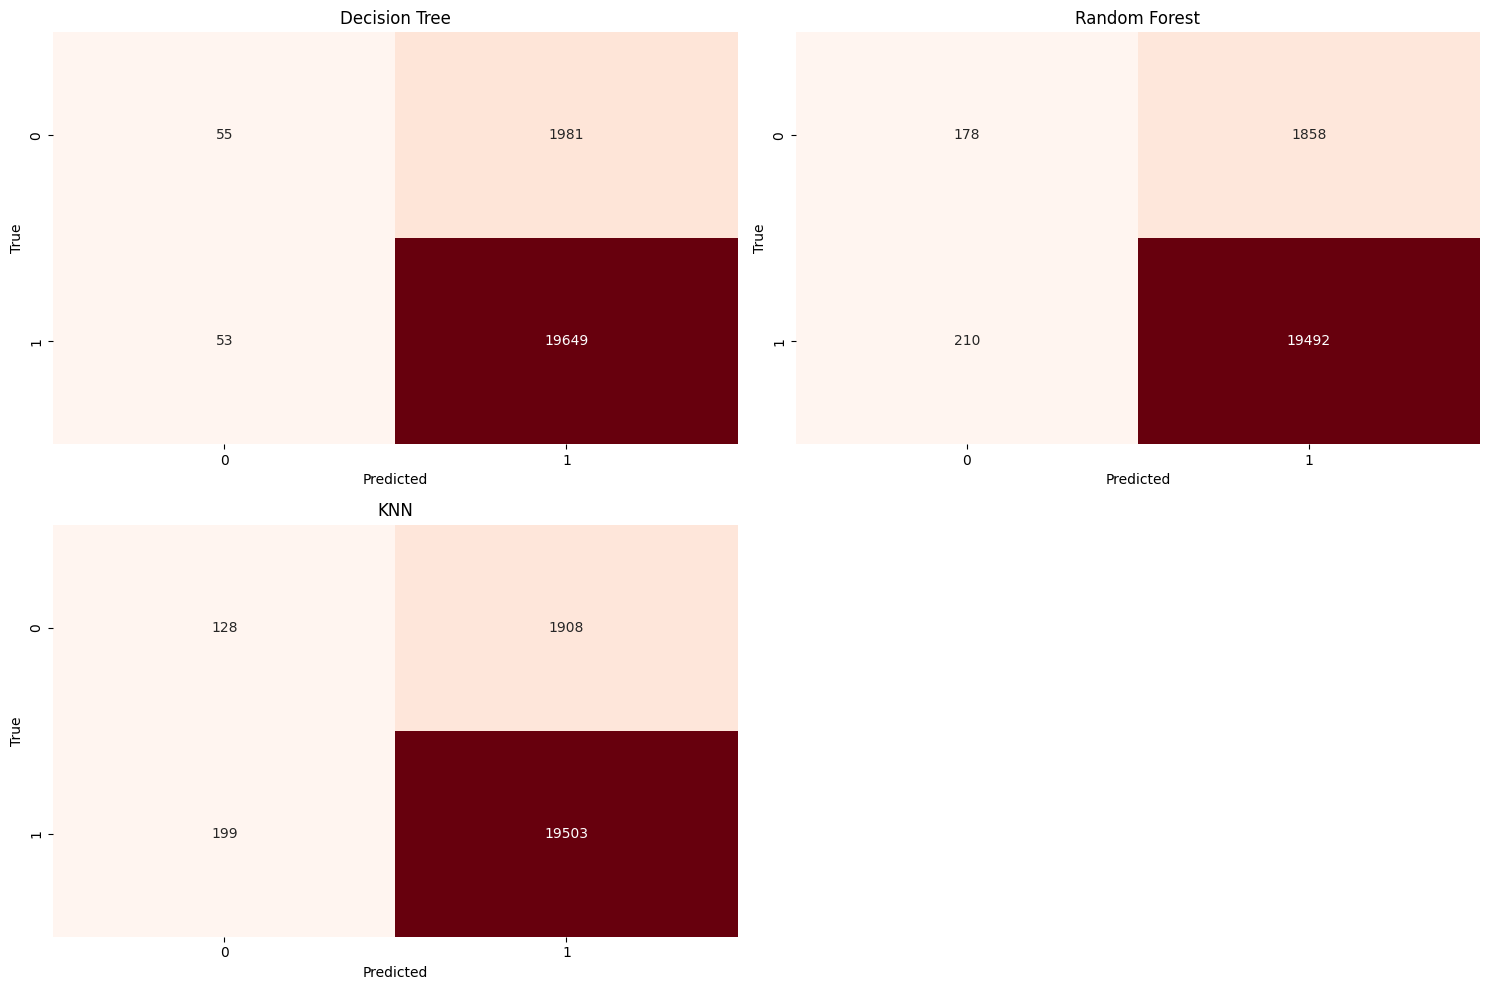

In [111]:
# plot confusion matrixes
plt.figure(figsize=(15, 10))
for i, row in conf_mxs.iterrows():
    plt.subplot(2, 2, i+1)
    sns.heatmap(row['cm'], annot=True, fmt='d', cmap='Reds', cbar=False)
    plt.title(row['model'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()

As we can see, these models seem to perform very well. All of them achieve accuracy, F1-score, recall and precision around 0.9.

Does this mean that we can move forward to more complex models? Not at all.
All these models are getting very low values for specificity, meaning they are not good at capturing the negative class. This indicates the presence of very underfitted models, biased towards the positive class.

The confusion matrices resulting of each of these models prove that these models are not capable of correclty predicting a considerbale amount of negative cases.

In [112]:
# Frequency of target variable
print(y.value_counts(dropna=False))

# Frequency of target variable in percentage
print(y.value_counts(dropna=False, normalize=True))

health_ins
1    65553
0     6905
Name: count, dtype: int64
health_ins
1    0.904703
0    0.095297
Name: proportion, dtype: float64


Once we are using the trainig dataset to both train and validate our models, the "classical" metrics are not enough to reason about model performance. This dataset is highly imbalanced, meaning that both test and validation partitions will have a similar distribution. So, if we use a model that learns to predict everything as positive, when tested in a dataset with similar distribution, it will achieve very good accruacy, F1, ... metrics.

In [113]:
# Frequency of target variable in train set
print(y_train.value_counts(dropna=False, normalize=True))

# Frequency of target variable in test set
print(y_test.value_counts(dropna=False, normalize=True))

health_ins
1    0.904002
0    0.095998
Name: proportion, dtype: float64
health_ins
1    0.906339
0    0.093661
Name: proportion, dtype: float64


Next section will focus on how to address this issue, by aplying balacing techniques to the dataset.

# Dealing with imbalanced data

In this section, we will apply some SMOTE techniques to the training data in order to solve the highly imbalanced data problem.

We will try several SMOTE techniques to generate some datasets. Then, these datasets will be compared using some data-quality metrics (using `problexity` library)

The SMOTE techniques that we will use are:
- **Borderline SMOTE** (over-sampling the minority class reinforcing the border between the classes)
- **ADASYN** (Adaptive Synthetic Sampling: focuses on generating samples of minotiy class that are harder to classify)
- **SMOTE-TL** (SMOTE Tomek Links: combines over-sampling of the minority class with under-sampling of the majority class by removing Tomek links)
- **SMOTE-ENN** (SMOTE Edited Nearest Neighbors: combines over-sampling of the minority class with under-sampling of the majority class by cleaning the majority class with ENN)
- **SMOTE-SVM** (SMOTE Support Vector Machine: uses SVM to generate synthetic samples)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import problexity as pbx
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

In [2]:
df = pd.read_csv('../data/customer_cleaned.csv')
df.head()

,sex,is_employed,income,health_ins,num_vehicles,age,state_of_res,gas_usage,rooms,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented
0,1,1,-0.34,1,0.00,0.04,0.0,2.71,0.4,0,0,1,0,1,0,0,0
1,0,0,-0.32,1,0.00,0.78,0.0,-0.60,1.0,1,0,0,0,0,0,0,1
2,0,1,-0.36,1,0.33,0.13,0.0,-0.01,0.4,0,0,1,0,0,1,0,0
3,0,0,-0.07,1,0.17,0.92,0.0,1.27,0.2,0,0,0,1,1,0,0,0
4,1,1,-0.05,1,0.33,0.59,0.0,-0.60,0.2,1,0,0,0,0,0,0,1


In [3]:
X = df.drop('health_ins', axis=1)
y = df['health_ins']

In [4]:
# Number of cases and percentage of each class in the original dataset
print(f"Original dataset: {y.value_counts()}")
print(f"Percentage of each class in the original dataset: {y.value_counts(normalize=True)}")

Original dataset: health_ins
1    65553
0     6905
Name: count, dtype: int64
Percentage of each class in the original dataset: health_ins
1    0.904703
0    0.095297
Name: proportion, dtype: float64


## SMOTE Edited Nearest Neighbors (SMOTE-ENN)

In [5]:
smote_enn = SMOTEENN(random_state=42,n_jobs=-1)
X_resampled_smoteenn, y_resampled_smoteenn = smote_enn.fit_resample(X, y)
print(f"SMOTEENN dataset: {y_resampled_smoteenn.value_counts()}")
print(f"Percentage of each class in the SMOTEENN dataset: {y_resampled_smoteenn.value_counts(normalize=True)}")

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


SMOTEENN dataset: health_ins
0    60158
1    44849
Name: count, dtype: int64
Percentage of each class in the SMOTEENN dataset: health_ins
0    0.572895
1    0.427105
Name: proportion, dtype: float64


## SMOTE Tomek Links (SMOTE-TL)

In [6]:
smote_tl = SMOTETomek(random_state=42,n_jobs=-1)
X_resampled_smotetl, y_resampled_smotetl = smote_tl.fit_resample(X, y)
print(f"SMOTETomek dataset: {y_resampled_smotetl.value_counts()}")
print(f"Percentage of each class in the SMOTETomek dataset: {y_resampled_smotetl.value_counts(normalize=True)}")

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


SMOTETomek dataset: health_ins
1    64826
0    64826
Name: count, dtype: int64
Percentage of each class in the SMOTETomek dataset: health_ins
1    0.5
0    0.5
Name: proportion, dtype: float64


## Borderline SMOTE

In [7]:
borderline_smote = BorderlineSMOTE(random_state=42,n_jobs=-1)
X_resampled_borderline, y_resampled_borderline = borderline_smote.fit_resample(X, y)
print(f"BorderlineSMOTE dataset: {y_resampled_borderline.value_counts()}")
print(f"Percentage of each class in the BorderlineSMOTE dataset: {y_resampled_borderline.value_counts(normalize=True)}")

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


BorderlineSMOTE dataset: health_ins
1    65553
0    65553
Name: count, dtype: int64
Percentage of each class in the BorderlineSMOTE dataset: health_ins
1    0.5
0    0.5
Name: proportion, dtype: float64


## Borderline SMOTE over SMOTE-ENN

In [8]:
X_resampled_enn_borderline, y_resampled_enn_borderline = borderline_smote.fit_resample(X_resampled_smoteenn, y_resampled_smoteenn)
print(f"BorderlineSMOTE + ENN dataset: {y_resampled_enn_borderline.value_counts()}")
print(f"Percentage of each class in the BorderlineSMOTE + ENN dataset: {y_resampled_enn_borderline.value_counts(normalize=True)}")

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


BorderlineSMOTE + ENN dataset: health_ins
0    60158
1    60158
Name: count, dtype: int64
Percentage of each class in the BorderlineSMOTE + ENN dataset: health_ins
0    0.5
1    0.5
Name: proportion, dtype: float64


## ADASYN

In [9]:
adasyn_smote = ADASYN(random_state=42,n_jobs=-1)
X_resampled_adasyn, y_resampled_adasyn = adasyn_smote.fit_resample(X, y)
print(f"ADASYN dataset: {y_resampled_adasyn.value_counts()}")
print(f"Percentage of each class in the ADASYN dataset: {y_resampled_adasyn.value_counts(normalize=True)}")

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


ADASYN dataset: health_ins
0    66356
1    65553
Name: count, dtype: int64
Percentage of each class in the ADASYN dataset: health_ins
0    0.503044
1    0.496956
Name: proportion, dtype: float64


## SMOTE-SVM //TODO

In [10]:
sm_svm = SVMSMOTE(random_state=42,n_jobs=-1)
X_resampled_smote_svm, y_resampled_smote_svm = sm_svm.fit_resample(X, y)
print(f"ADASYN dataset: {y_resampled_smote_svm.value_counts()}")
print(f"Percentage of each class in the ADASYN dataset: {y_resampled_smote_svm.value_counts(normalize=True)}")

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:437: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


ADASYN dataset: health_ins
1    65553
0    65553
Name: count, dtype: int64
Percentage of each class in the ADASYN dataset: health_ins
1    0.5
0    0.5
Name: proportion, dtype: float64


## Comparison of the datasets

In [14]:
datasets = {
    'original': (X, y),
    'smote-enn': (X_resampled_smoteenn, y_resampled_smoteenn),
    'borderline': (X_resampled_borderline, y_resampled_borderline),
    'smote-tl': (X_resampled_smotetl, y_resampled_smotetl),
    'enn-borderline': (X_resampled_enn_borderline, y_resampled_enn_borderline),
    'adasyn-smote': (X_resampled_adasyn, y_resampled_adasyn),
    'smote-svm': (X_resampled_smote_svm, y_resampled_smote_svm)
}

fb_measures = pd.DataFrame([], columns=['dataset', 'f1', 'f2', 'f3', 'f4'])

for dataset, (X, y) in datasets.items():
    print(f'Calculating metrics for {dataset}')
    f1 = round(pbx.f1(X, y),3)
    f2 = round(pbx.f2(X, y),3)
    f3 = round(pbx.f3(X, y),3)
    f4 = round(pbx.f4(X, y),3)
    fb_measures.loc[len(fb_measures)] = [dataset, f1, f2, f3, f4]

fb_measures

Calculating metrics for original
Calculating metrics for smote-enn
Calculating metrics for borderline
Calculating metrics for smote-tl
Calculating metrics for enn-borderline
Calculating metrics for adasyn-smote
Calculating metrics for smote-svm


,dataset,f1,f2,f3,f4
0,original,0.815,0.288,0.997,0.997
1,smote-enn,0.677,0.282,0.996,0.996
2,borderline,0.769,0.288,0.997,0.997
3,smote-tl,0.796,0.288,0.997,0.997
4,enn-borderline,0.766,0.282,0.996,0.996
5,adasyn-smote,0.815,0.288,0.997,0.997
6,smote-svm,0.753,0.139,0.990,0.968


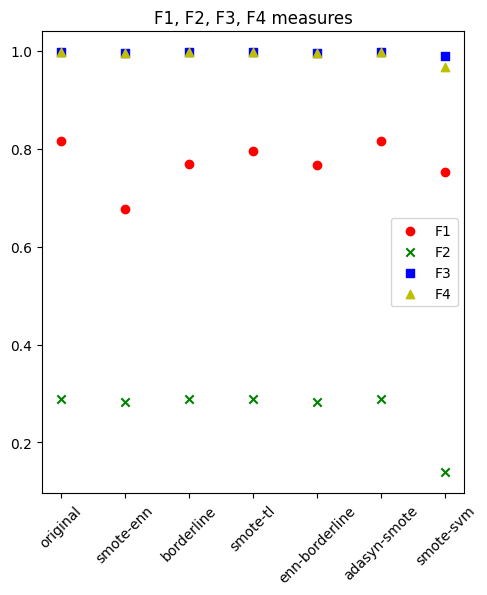

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(fb_measures['dataset'], fb_measures['f1'], color='r', label='F1', marker='o')
plt.scatter(fb_measures['dataset'], fb_measures['f2'], color='g', label='F2', marker='x')
plt.scatter(fb_measures['dataset'], fb_measures['f3'], color='b', label='F3', marker='s')
plt.scatter(fb_measures['dataset'], fb_measures['f4'], color='y', label='F4', marker='^')
plt.xticks(rotation=45)
plt.legend()
plt.title('F1, F2, F3, F4 measures')
plt.show()

Remembering the meaning of each measure:
- **F1**: class separability
- **F2**: feature overlap
- **F3**: best single feature
- **F4**: combined feature effectiveness

In [17]:
df_balanced = pd.concat([X_resampled_smote_svm, X_resampled_smote_svm], axis=1)
df_balanced.to_csv('../data/balanced.csv', index=False)

We have choosen the dataset generated by **SVM SMOTE** as the best one. It is saved in the file `balanced.csv` in order to be used in next steps for training models.

# Model Selection

Now that we have treated the imbalance issue in the training data, we can proceed to a more extensive exploration of classification algorithms. The objective of this section is to identify the best model for the problem, in order to use it for the final predictions.

The following algorithms will be tested:
- Decision Tree
- Random Forest
- K-Nearest Neighbors
- Support Vector Machine
- Logistic Regression
- Neural Network (Multi-Layer Perceptron)

For evaluating these models, we will consider several performance metrics: accuracy, F1 score and specificity. We will also look at the confusion matrix of each models. Moreover, we will divide the full training set into training and validation sets, in order to perform hyperparameter tuning.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [2]:
# Load the treated dataset
df = pd.read_csv('../data/balanced.csv')
df.shape

(131909, 17)

In [3]:
df.head(10)

,sex,is_employed,income,num_vehicles,age,state_of_res,gas_usage,rooms,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,health_ins
0,1,1,-0.34,0.00,0.04,0.0,2.71,0.4,0,0,1,0,1,0,0,0,1
1,0,0,-0.32,0.00,0.78,0.0,-0.60,1.0,1,0,0,0,0,0,0,1,1
2,0,1,-0.36,0.33,0.13,0.0,-0.01,0.4,0,0,1,0,0,1,0,0,1
3,0,0,-0.07,0.17,0.92,0.0,1.27,0.2,0,0,0,1,1,0,0,0,1
4,1,1,-0.05,0.33,0.59,0.0,-0.60,0.2,1,0,0,0,0,0,0,1,1
5,1,0,-0.53,0.33,0.71,0.0,2.55,1.0,0,1,0,0,1,0,0,0,1
6,0,1,-0.28,0.33,0.06,0.0,-0.60,0.4,0,1,0,0,0,0,0,1,0
7,0,0,-0.12,0.33,0.67,0.0,0.15,0.8,0,1,0,0,1,0,0,0,1
8,0,1,-0.29,0.83,0.08,0.0,-0.60,0.6,0,0,1,0,1,0,0,0,1
9,1,1,-0.18,0.50,0.42,0.0,-0.33,1.0,0,1,0,0,0,1,0,0,1


In [4]:
# Splitting the columns into features and target
X = df.drop(['health_ins'], axis=1)
y = df['health_ins']

X.shape

(131909, 16)

In [5]:
# Divide the data into training and test sets (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [6]:
# Functio to rexeive results of a model and plot its evolution for a given parameter
def plot_measures(measures):
    parameters = measures.iloc[:,0]
    accuracy = measures.iloc[:,1]
    precision = measures.iloc[:,2]
    recall = measures.iloc[:,3]
    f1 = measures.iloc[:,4]
    spec = measures.iloc[:,5]

    sns.lineplot(x=parameters, y=accuracy, label='accuracy')
    sns.lineplot(x=parameters, y=precision, label='precision')
    sns.lineplot(x=parameters, y=recall, label='recall')
    sns.lineplot(x=parameters, y=f1, label='f1')
    sns.lineplot(x=parameters, y=spec, label='specificity')

In [7]:
# Function to, given the prediction of a model, return its: accuracy, precision, recall, f1 and confusion matrix
def get_metrics(y_pred):
    acc = round(accuracy_score(y_test, y_pred),3)
    prec = round(precision_score(y_test, y_pred),3)
    rec = round(recall_score(y_test, y_pred),3)
    f1 = round(f1_score(y_test, y_pred),3)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    spec = round(tn / (tn+fp),3)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'specificity': spec, 'cm': cm}

In [8]:
# Dataframe to store the results of the models
models = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])

## Decision Trees

Fitting model with 1
Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with 21
Fitting model with 23
Fitting model with 25
Fitting model with 27
Fitting model with 29
Fitting model with None


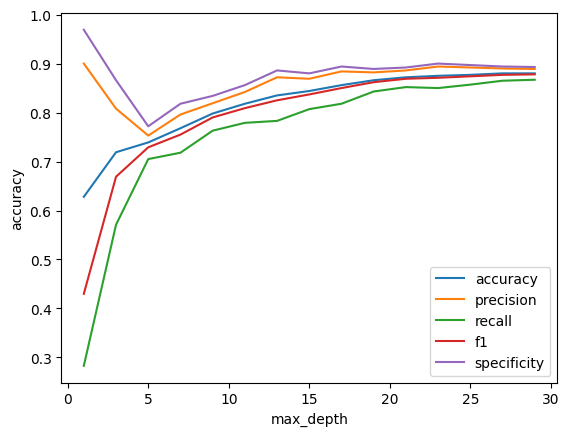

In [9]:
dec_tree_measures = pd.DataFrame(columns=['max_depth', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(1, 30, 2)) + [None]

for max_depth in parameters:
    print(f'Fitting model with {max_depth}')
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'max_depth': max_depth, **measures}
    dec_tree_measures.loc[len(dec_tree_measures)] = new_row


plot_measures(dec_tree_measures)

In [10]:
row = dec_tree_measures[dec_tree_measures['max_depth'] == 15]
models.loc[len(models)] = {'model': 'Decision Tree', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.844,0.869,0.807,0.837,0.88,"[[17506, 2386], [3800, 15881]]"


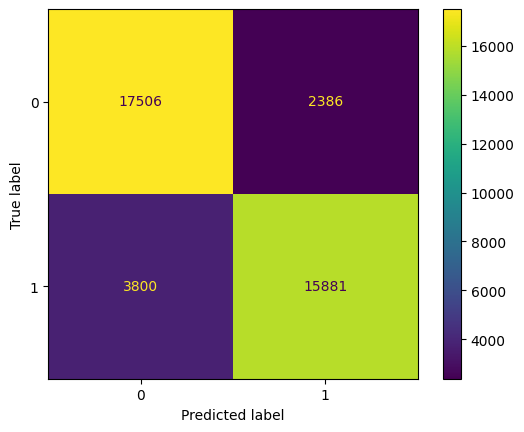

In [11]:
ConfusionMatrixDisplay(row.iloc[0,6]).plot()

## Random Forest

Fitting model with 10
Fitting model with 20
Fitting model with 50
Fitting model with 75
Fitting model with 100
Fitting model with 200
Fitting model with 500


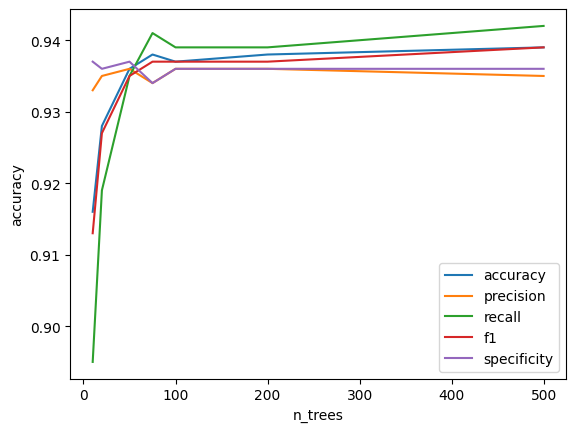

In [12]:
rf_measures = pd.DataFrame(columns=['n_trees', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = [10, 20, 50, 75, 100, 200, 500]

for n_trees in parameters:
    print(f'Fitting model with {n_trees}')
    model = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_trees': n_trees, **measures}
    rf_measures.loc[len(rf_measures)] = new_row

plot_measures(rf_measures)

In [13]:
row = rf_measures[rf_measures['n_trees'] == 100]
models.loc[len(models)] = {'model': 'Random Forest', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.844,0.869,0.807,0.837,0.880,"[[17506, 2386], [3800, 15881]]"
1,Random Forest,0.937,0.936,0.939,0.937,0.936,"[[18619, 1273], [1204, 18477]]"


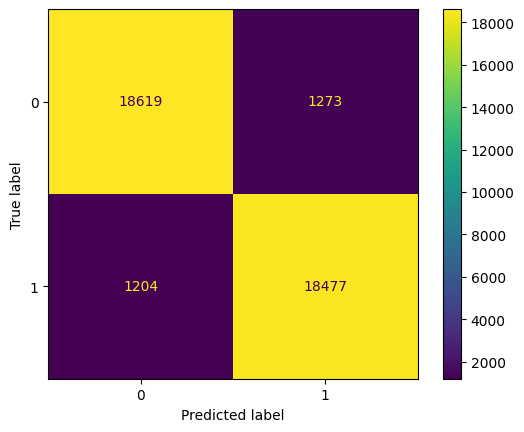

In [14]:
ConfusionMatrixDisplay(row.iloc[0,6]).plot()

## K Nearest Neighbors

Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with 21
Fitting model with 23
Fitting model with 25
Fitting model with 27
Fitting model with 29


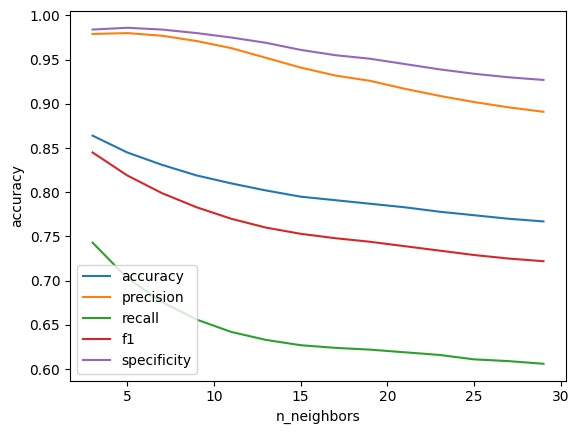

In [15]:
knn_measures = pd.DataFrame(columns=['n_neighbors', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(3, 30, 2))

for n_neighbors in parameters:
    print(f'Fitting model with {n_neighbors}')
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_neighbors': n_neighbors, **measures}
    knn_measures.loc[len(knn_measures)] = new_row

plot_measures(knn_measures)

In [16]:
row = knn_measures[knn_measures['n_neighbors'] == 5]
models.loc[len(models)] = {'model': 'KNN', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.844,0.869,0.807,0.837,0.880,"[[17506, 2386], [3800, 15881]]"
1,Random Forest,0.937,0.936,0.939,0.937,0.936,"[[18619, 1273], [1204, 18477]]"
2,KNN,0.845,0.980,0.703,0.819,0.986,"[[19609, 283], [5841, 13840]]"


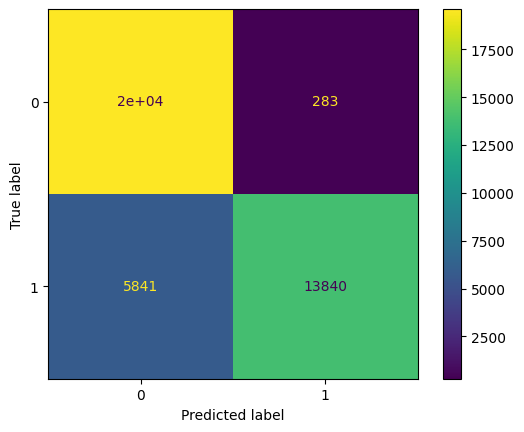

In [17]:
ConfusionMatrixDisplay(row.iloc[0,6]).plot()

## Logistic Regression

In [18]:
parameters = {
    'C': [0.01, 0.1, 1, 10, 50],
    'solver': ['sag', 'saga', 'lbfgs'],
    'max_iter': [500, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring='f1', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END C=0.01, max_iter=500, solver=lbfgs;, score=0.688 total time=   0.1s
[CV 2/5] END C=0.01, max_iter=500, solver=lbfgs;, score=0.692 total time=   0.1s
[CV 3/5] END C=0.01, max_iter=500, solver=lbfgs;, score=0.688 total time=   0.1s
[CV 1/5] END ..C=0.01, max_iter=500, solver=sag;, score=0.688 total time=   0.4s
[CV 4/5] END ..C=0.01, max_iter=500, solver=sag;, score=0.696 total time=   0.4s
[CV 4/5] END C=0.01, max_iter=500, solver=lbfgs;, score=0.696 total time=   0.1s
[CV 5/5] END ..C=0.01, max_iter=500, solver=sag;, score=0.683 total time=   0.4s
[CV 2/5] END ..C=0.01, max_iter=500, solver=sag;, score=0.692 total time=   0.4s
[CV 3/5] END ..C=0.01, max_iter=500, solver=sag;, score=0.688 total time=   0.5s
[CV 5/5] END C=0.01, max_iter=500, solver=lbfgs;, score=0.683 total time=   0.1s
[CV 4/5] END .C=0.01, max_iter=500, solver=saga;, score=0.696 total time=   0.6s
[CV 1/5] END .C=0.01, max_iter=1000, solver=sag

/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ....C=10, max_iter=500, solver=sag;, score=0.694 total time=  11.1s
[CV 3/5] END ....C=10, max_iter=500, solver=sag;, score=0.692 total time=  11.1s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ....C=10, max_iter=500, solver=sag;, score=0.691 total time=  11.6s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ....C=10, max_iter=500, solver=sag;, score=0.701 total time=  11.4s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ....C=10, max_iter=500, solver=sag;, score=0.686 total time=  11.5s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=10, max_iter=500, solver=saga;, score=0.691 total time=  12.6s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=10, max_iter=500, solver=saga;, score=0.694 total time=  13.3s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=10, max_iter=500, solver=saga;, score=0.692 total time=  13.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=10, max_iter=500, solver=saga;, score=0.686 total time=  13.2s
[CV 1/5] END .C=10, max_iter=1000, solver=lbfgs;, score=0.691 total time=   0.2s
[CV 2/5] END .C=10, max_iter=1000, solver=lbfgs;, score=0.694 total time=   0.2s
[CV 3/5] END .C=10, max_iter=1000, solver=lbfgs;, score=0.692 total time=   0.2s
[CV 4/5] END .C=10, max_iter=1000, solver=lbfgs;, score=0.701 total time=   0.1s
[CV 4/5] END ...C=10, max_iter=500, solver=saga;, score=0.700 total time=  14.7s
[CV 5/5] END .C=10, max_iter=1000, solver=lbfgs;, score=0.686 total time=   0.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=10, max_iter=1000, solver=sag;, score=0.701 total time=  11.4s
[CV 1/5] END ...C=10, max_iter=1000, solver=sag;, score=0.691 total time=  15.1s
[CV 3/5] END ...C=10, max_iter=1000, solver=sag;, score=0.692 total time=  14.4s
[CV 2/5] END ...C=10, max_iter=1000, solver=sag;, score=0.694 total time=  15.7s
[CV 5/5] END ...C=10, max_iter=1000, solver=sag;, score=0.686 total time=  16.1s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ....C=50, max_iter=500, solver=sag;, score=0.694 total time=  10.7s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ....C=50, max_iter=500, solver=sag;, score=0.691 total time=  12.0s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ....C=50, max_iter=500, solver=sag;, score=0.692 total time=  11.3s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ....C=50, max_iter=500, solver=sag;, score=0.701 total time=  11.2s
[CV 1/5] END ..C=50, max_iter=500, solver=lbfgs;, score=0.691 total time=   0.2s
[CV 2/5] END ..C=50, max_iter=500, solver=lbfgs;, score=0.694 total time=   0.2s
[CV 5/5] END ....C=50, max_iter=500, solver=sag;, score=0.686 total time=  11.2s
[CV 3/5] END ..C=50, max_iter=500, solver=lbfgs;, score=0.692 total time=   0.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..C=50, max_iter=500, solver=lbfgs;, score=0.701 total time=   0.2s
[CV 5/5] END ..C=50, max_iter=500, solver=lbfgs;, score=0.687 total time=   0.2s
[CV 4/5] END ..C=10, max_iter=1000, solver=saga;, score=0.701 total time=  22.1s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..C=10, max_iter=1000, solver=saga;, score=0.691 total time=  26.1s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=50, max_iter=500, solver=saga;, score=0.691 total time=  13.5s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..C=10, max_iter=1000, solver=saga;, score=0.694 total time=  26.6s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..C=10, max_iter=1000, solver=saga;, score=0.692 total time=  25.5s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=50, max_iter=500, solver=saga;, score=0.694 total time=  13.6s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..C=10, max_iter=1000, solver=saga;, score=0.686 total time=  25.8s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=50, max_iter=500, solver=saga;, score=0.692 total time=  13.5s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=50, max_iter=500, solver=saga;, score=0.686 total time=  13.8s
[CV 1/5] END .C=50, max_iter=1000, solver=lbfgs;, score=0.691 total time=   0.1s
[CV 2/5] END .C=50, max_iter=1000, solver=lbfgs;, score=0.694 total time=   0.2s
[CV 3/5] END .C=50, max_iter=1000, solver=lbfgs;, score=0.692 total time=   0.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=50, max_iter=500, solver=saga;, score=0.701 total time=  14.9s
[CV 4/5] END .C=50, max_iter=1000, solver=lbfgs;, score=0.701 total time=   0.2s
[CV 5/5] END .C=50, max_iter=1000, solver=lbfgs;, score=0.687 total time=   0.2s
[CV 4/5] END ...C=50, max_iter=1000, solver=sag;, score=0.701 total time=  18.7s
[CV 3/5] END ...C=50, max_iter=1000, solver=sag;, score=0.692 total time=  21.9s
[CV 2/5] END ...C=50, max_iter=1000, solver=sag;, score=0.694 total time=  22.6s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=50, max_iter=1000, solver=sag;, score=0.691 total time=  22.9s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=50, max_iter=1000, solver=sag;, score=0.687 total time=  22.4s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..C=50, max_iter=1000, solver=saga;, score=0.691 total time=  25.0s
[CV 2/5] END ..C=50, max_iter=1000, solver=saga;, score=0.694 total time=  24.8s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..C=50, max_iter=1000, solver=saga;, score=0.692 total time=  25.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..C=50, max_iter=1000, solver=saga;, score=0.686 total time=  23.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..C=50, max_iter=1000, solver=saga;, score=0.701 total time=  23.6s


{'C': 50, 'max_iter': 500, 'solver': 'lbfgs'}

In [19]:
best_params = {'C': 50, 'max_iter': 500, 'solver': 'lbfgs'}

In [20]:
lr = LogisticRegression(**best_params)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
measures = get_metrics(y_pred)
measures

{'accuracy': 0.714,
 'precision': np.float64(0.738),
 'recall': np.float64(0.66),
 'f1': np.float64(0.697),
 'specificity': np.float64(0.768),
 'cm': array([[15281,  4611],
        [ 6697, 12984]])}

In [21]:
models.loc[len(models)] = {'model': 'Logistic Regression', **measures}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.844,0.869,0.807,0.837,0.880,"[[17506, 2386], [3800, 15881]]"
1,Random Forest,0.937,0.936,0.939,0.937,0.936,"[[18619, 1273], [1204, 18477]]"
2,KNN,0.845,0.980,0.703,0.819,0.986,"[[19609, 283], [5841, 13840]]"
3,Logistic Regression,0.714,0.738,0.660,0.697,0.768,"[[15281, 4611], [6697, 12984]]"


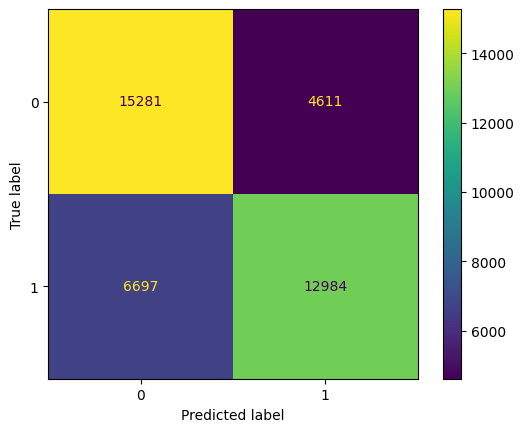

In [22]:
ConfusionMatrixDisplay(measures['cm']).plot()

## Support Vector Machine

In [23]:
'''
parameters = {
    'kernel': ['rbf'],
    'random_state': [42],
}

grid_search = GridSearchCV(SVC(), parameters, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params
'''

"\nparameters = {\n    'kernel': ['rbf'],\n    'random_state': [42],\n}\n\ngrid_search = GridSearchCV(SVC(), parameters, cv=5, scoring='f1', n_jobs=-1)\ngrid_search.fit(X_train, y_train)\nbest_params = grid_search.best_params_\nbest_params\n"

In [24]:
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
measures = get_metrics(y_pred)
measures

{'accuracy': 0.745,
 'precision': np.float64(0.821),
 'recall': np.float64(0.624),
 'f1': np.float64(0.709),
 'specificity': np.float64(0.866),
 'cm': array([[17221,  2671],
        [ 7404, 12277]])}

In [25]:
models.loc[len(models)] = {'model': 'SVM', **measures}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.844,0.869,0.807,0.837,0.880,"[[17506, 2386], [3800, 15881]]"
1,Random Forest,0.937,0.936,0.939,0.937,0.936,"[[18619, 1273], [1204, 18477]]"
2,KNN,0.845,0.980,0.703,0.819,0.986,"[[19609, 283], [5841, 13840]]"
3,Logistic Regression,0.714,0.738,0.660,0.697,0.768,"[[15281, 4611], [6697, 12984]]"
4,SVM,0.745,0.821,0.624,0.709,0.866,"[[17221, 2671], [7404, 12277]]"


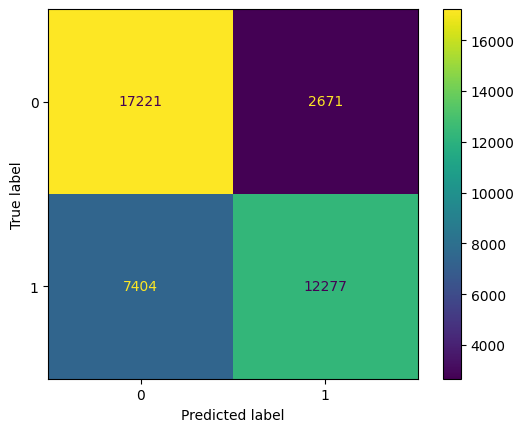

In [26]:
ConfusionMatrixDisplay(measures['cm']).plot()

## XGBOOST

In [27]:
parameters = {
    'objective':['binary:logistic'],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}
grid_search = GridSearchCV(xgb.XGBClassifier(), parameters, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.1,
 'max_depth': 7,
 'objective': 'binary:logistic',
 'subsample': 0.5}

In [28]:
xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
measures = get_metrics(y_pred)
measures

{'accuracy': 0.935,
 'precision': np.float64(0.902),
 'recall': np.float64(0.975),
 'f1': np.float64(0.937),
 'specificity': np.float64(0.895),
 'cm': array([[17811,  2081],
        [  493, 19188]])}

In [29]:
models.loc[len(models)] = {'model': 'xgb', **measures}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.844,0.869,0.807,0.837,0.880,"[[17506, 2386], [3800, 15881]]"
1,Random Forest,0.937,0.936,0.939,0.937,0.936,"[[18619, 1273], [1204, 18477]]"
2,KNN,0.845,0.980,0.703,0.819,0.986,"[[19609, 283], [5841, 13840]]"
3,Logistic Regression,0.714,0.738,0.660,0.697,0.768,"[[15281, 4611], [6697, 12984]]"
4,SVM,0.745,0.821,0.624,0.709,0.866,"[[17221, 2671], [7404, 12277]]"
5,xgb,0.935,0.902,0.975,0.937,0.895,"[[17811, 2081], [493, 19188]]"


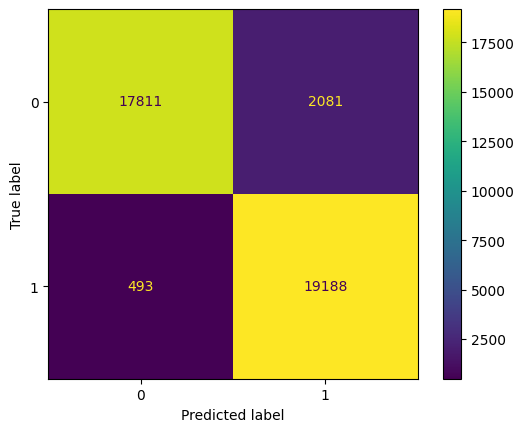

In [30]:
ConfusionMatrixDisplay(measures['cm']).plot()

## Multi-Layer Perceptron (Neural Network)

In [31]:
parameters = {
    'hidden_layer_sizes': [(10,), (12, 6), (13,9,5)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam'],
    'max_iter': [500, 1000],
    'random_state': [42],
    'learning_rate_init': [0.001, 0.01, 0.1],
}

grid_search = GridSearchCV(MLPClassifier(), parameters, cv=5, scoring='f1', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 2/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=500, random_state=42, solver=adam;, score=0.720 total time=   3.6s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=500, random_state=42, solver=adam;, score=0.712 total time=   4.1s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=500, random_state=42, solver=adam;, score=0.729 total time=   4.7s
[CV 4/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=500, random_state=42, solver=adam;, score=0.728 total time=   4.9s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=500, random_state=42, solver=adam;, score=0.729 total time=  11.3s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=500, random_state=42, solver=adam;, s

{'activation': 'logistic',
 'hidden_layer_sizes': (13, 9, 5),
 'learning_rate_init': 0.01,
 'max_iter': 500,
 'random_state': 42,
 'solver': 'adam'}

In [32]:
best_params = {'activation': 'logistic',
                'hidden_layer_sizes': (13, 9, 5),
                'learning_rate_init': 0.01,
                'max_iter': 500,
                'random_state': 42,
                'solver': 'adam'}

In [33]:
mlp = MLPClassifier(**best_params)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
measures = get_metrics(y_pred)
measures

{'accuracy': 0.751,
 'precision': np.float64(0.787),
 'recall': np.float64(0.685),
 'f1': np.float64(0.732),
 'specificity': np.float64(0.817),
 'cm': array([[16253,  3639],
        [ 6209, 13472]])}

In [34]:
models.loc[len(models)] = {'model': 'MLP', **measures}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.844,0.869,0.807,0.837,0.880,"[[17506, 2386], [3800, 15881]]"
1,Random Forest,0.937,0.936,0.939,0.937,0.936,"[[18619, 1273], [1204, 18477]]"
2,KNN,0.845,0.980,0.703,0.819,0.986,"[[19609, 283], [5841, 13840]]"
3,Logistic Regression,0.714,0.738,0.660,0.697,0.768,"[[15281, 4611], [6697, 12984]]"
4,SVM,0.745,0.821,0.624,0.709,0.866,"[[17221, 2671], [7404, 12277]]"
5,xgb,0.935,0.902,0.975,0.937,0.895,"[[17811, 2081], [493, 19188]]"
6,MLP,0.751,0.787,0.685,0.732,0.817,"[[16253, 3639], [6209, 13472]]"


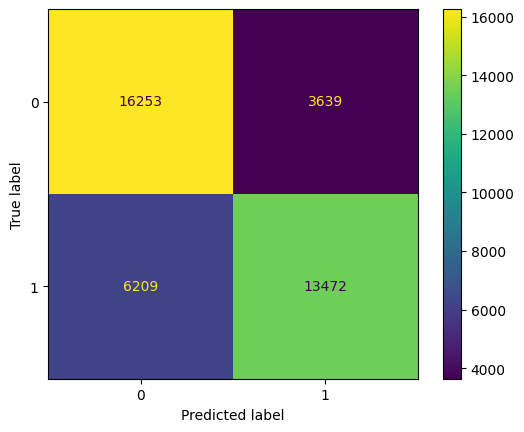

In [35]:
ConfusionMatrixDisplay(measures['cm']).plot()

## Bayesian Classifier

In [36]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
measures = get_metrics(y_pred)
measures

{'accuracy': 0.688,
 'precision': np.float64(0.744),
 'recall': np.float64(0.567),
 'f1': np.float64(0.644),
 'specificity': np.float64(0.807),
 'cm': array([[16055,  3837],
        [ 8524, 11157]])}

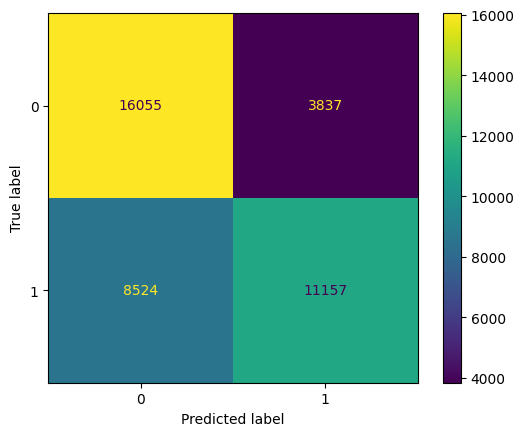

In [37]:
ConfusionMatrixDisplay(measures['cm']).plot()

In [38]:
models.loc[len(models)] = {'model': 'Naive Bayes', **measures}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.844,0.869,0.807,0.837,0.880,"[[17506, 2386], [3800, 15881]]"
1,Random Forest,0.937,0.936,0.939,0.937,0.936,"[[18619, 1273], [1204, 18477]]"
2,KNN,0.845,0.980,0.703,0.819,0.986,"[[19609, 283], [5841, 13840]]"
3,Logistic Regression,0.714,0.738,0.660,0.697,0.768,"[[15281, 4611], [6697, 12984]]"
4,SVM,0.745,0.821,0.624,0.709,0.866,"[[17221, 2671], [7404, 12277]]"
5,xgb,0.935,0.902,0.975,0.937,0.895,"[[17811, 2081], [493, 19188]]"
6,MLP,0.751,0.787,0.685,0.732,0.817,"[[16253, 3639], [6209, 13472]]"
7,Naive Bayes,0.688,0.744,0.567,0.644,0.807,"[[16055, 3837], [8524, 11157]]"


## Overall comparison of the models

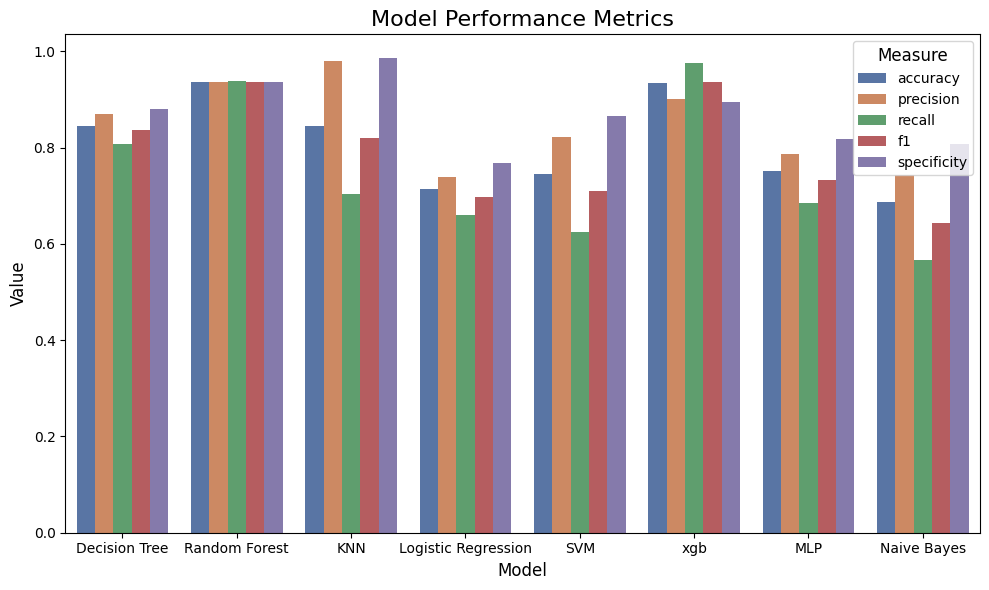

In [39]:
melted = models.melt(id_vars="model", value_vars=["accuracy", "precision", "recall", "f1", "specificity"],
                     var_name="measure", value_name="value")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="model", y="value", hue="measure", palette="deep")

plt.title("Model Performance Metrics", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Measure", fontsize=10, title_fontsize=12)
plt.tight_layout()

plt.show()

After this analysis, we chose the Random Forest (100 trees) as the best model to make the final predictions.

# Preprocessing of testing data

This section will be dedicated to applying the same preprocessing steps to the testing data as we did for the training data. The objective is to obtain a testing dataset that is ready to be used for prediction, made by models trained on the training data.

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [3]:
# Load the original dataset
df = pd.read_csv('../data/customer_test_masked.csv')
print(df.shape)
print(df.columns)
df['income'].min()

(804, 15)
Index(['Unnamed: 0', 'custid', 'sex', 'is_employed', 'income',
       'marital_status', 'health_ins', 'housing_type', 'num_vehicles', 'age',
       'state_of_res', 'code_column', 'gas_usage', 'rooms', 'recent_move_b'],
      dtype='object')


np.float64(0.0)

In [53]:
# people with missing values in 'is_employed' will be considered as unemployed
df['is_employed'] = df['is_employed'].fillna(False)
df['is_employed'].value_counts()

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_8532/1844132814.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_employed'] = df['is_employed'].fillna(False)


is_employed
True     507
False    297
Name: count, dtype: int64

In [54]:
# We can also drop the target column
df.drop(['Unnamed: 0','code_column','recent_move_b', 'health_ins'], axis=1, inplace=True)
print(df.shape)
print(df.columns)

(804, 11)
Index(['custid', 'sex', 'is_employed', 'income', 'marital_status',
       'housing_type', 'num_vehicles', 'age', 'state_of_res', 'gas_usage',
       'rooms'],
      dtype='object')


In [55]:
df.isnull().sum()

custid             0
sex                0
is_employed        0
income             0
marital_status     0
housing_type      34
num_vehicles      34
age                0
state_of_res       0
gas_usage         34
rooms              0
dtype: int64

In [56]:
df['housing_type'].fillna(df['housing_type'].mode()[0], inplace=True)
df['num_vehicles'].fillna(df['num_vehicles'].median(), inplace=True)
df['gas_usage'].fillna(df['gas_usage'].median(), inplace=True)

/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_8532/1160625473.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['housing_type'].fillna(df['housing_type'].mode()[0], inplace=True)
/var/folders/sv/gxsvk5v96llb5jl5wq8sxllh0000gn/T/ipykernel_8532/1160625473.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

In [57]:
# For variable 'age', we will truncate values to 21-99. 
# Values outside this range will be replaced to th closest endpoint.
print(f'Max age: {df['age'].max()} | Min age: {df['age'].min()}')
df['age'] = df['age'].clip(lower=21, upper=99)
print(f'Max age: {df['age'].max()} | Min age: {df['age'].min()}')
print(df.shape)

Max age: 114 | Min age: 21
Max age: 99 | Min age: 21
(804, 11)


In [58]:
# Columns to be scaled to min-max range: 'age', 'num_vehicles', 'rooms'
min_max_columns = ['age', 'num_vehicles', 'rooms']
scaler = MinMaxScaler()
# Round the scaled values to 2 decimal places, to group similar values
df[min_max_columns] = scaler.fit_transform(df[min_max_columns]).round(2)
df[min_max_columns].describe()

,age,num_vehicles,rooms
count,804.000000,804.000000,804.000000
mean,0.309428,0.324005,0.500000
std,0.215016,0.190028,0.345258
min,0.000000,0.000000,0.000000
25%,0.130000,0.170000,0.200000
50%,0.280000,0.330000,0.400000
75%,0.460000,0.330000,0.800000
max,1.000000,1.000000,1.000000


In [59]:
# Columns to be scaled to standard normal distribution: 'income', 'gas_usage'
standard_columns = ['income', 'gas_usage']
scaler = StandardScaler()
df[standard_columns] = scaler.fit_transform(df[['income', 'gas_usage']]).round(2)
df[standard_columns].describe()

,income,gas_usage
count,804.000000,804.000000
mean,-0.000609,-0.001567
std,1.001039,1.001372
min,-0.790000,-0.630000
25%,-0.630000,-0.600000
50%,-0.265000,-0.600000
75%,0.220000,0.300000
max,9.440000,8.110000


In [60]:
df.head(10)

,custid,sex,is_employed,income,marital_status,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms
0,001115999_01,Male,False,-0.06,Married,Homeowner free and clear,0.17,0.78,Arkansas,-0.27,1.0
1,000566299_01,Male,True,0.22,Never married,Rented,0.17,0.24,New Mexico,0.11,0.8
2,001397329_01,Female,True,4.33,Married,Homeowner with mortgage/loan,0.50,0.42,Colorado,0.87,0.2
3,000843100_01,Female,False,-0.79,Married,Homeowner free and clear,0.17,0.55,California,-0.08,0.2
4,000260071_03,Male,True,0.22,Married,Homeowner with mortgage/loan,0.67,0.18,New Jersey,2.20,0.0
5,000254582_02,Male,True,2.24,Married,Homeowner with mortgage/loan,0.33,0.13,California,-0.61,0.2
6,000916197_03,Female,False,-0.79,Divorced/Separated,Homeowner with mortgage/loan,0.33,0.06,Kentucky,0.49,0.2
7,000295424_04,Female,True,-0.53,Married,Homeowner with mortgage/loan,0.33,0.51,Connecticut,-0.60,0.4
8,001284781_02,Female,False,-0.57,Married,Homeowner free and clear,0.67,0.64,North Carolina,-0.46,0.8
9,001021897_02,Male,True,0.47,Never married,Rented,0.33,0.13,Louisiana,-0.60,1.0


- sex - categorical nominal (binary)
- is_emplyed - categorical nominal (binary)
- income - numerical
- marital_status - categorical nominal (multiclass)
- health_ins - categorical nominal (binary)
- housing_type - categorical nominal (multiclass)
- num_vehicles - numerical
- age - numerical
- state_of_residence - categorical nominal (multiclass)
- gas_usage - numerical
- rooms - numerical

In [61]:
cols_label_encode = ['sex','is_employed', 'state_of_res']
cols_one_hot_encode = ['marital_status', 'housing_type']

In [62]:
label_encoder = LabelEncoder()
for col in cols_label_encode:
    df[col] = label_encoder.fit_transform(df[col])

In [63]:
df = pd.get_dummies(df, columns=cols_one_hot_encode)
df.head()

,custid,sex,is_employed,income,num_vehicles,age,state_of_res,gas_usage,rooms,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented
0,001115999_01,1,0,-0.06,0.17,0.78,3,-0.27,1.0,False,True,False,False,True,False,False,False
1,000566299_01,1,1,0.22,0.17,0.24,30,0.11,0.8,False,False,True,False,False,False,False,True
2,001397329_01,0,1,4.33,0.50,0.42,5,0.87,0.2,False,True,False,False,False,True,False,False
3,000843100_01,0,0,-0.79,0.17,0.55,4,-0.08,0.2,False,True,False,False,True,False,False,False
4,000260071_03,1,1,0.22,0.67,0.18,29,2.20,0.0,False,True,False,False,False,True,False,False


In [64]:
dummies = list(filter(lambda x: x.startswith(tuple(cols_one_hot_encode)), df.columns))
dummies

['marital_status_Divorced/Separated',
 'marital_status_Married',
 'marital_status_Never married',
 'marital_status_Widowed',
 'housing_type_Homeowner free and clear',
 'housing_type_Homeowner with mortgage/loan',
 'housing_type_Occupied with no rent',
 'housing_type_Rented']

In [65]:
for col in dummies:
    df[col] = label_encoder.fit_transform(df[col])

df.head()

,custid,sex,is_employed,income,num_vehicles,age,state_of_res,gas_usage,rooms,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented
0,001115999_01,1,0,-0.06,0.17,0.78,3,-0.27,1.0,0,1,0,0,1,0,0,0
1,000566299_01,1,1,0.22,0.17,0.24,30,0.11,0.8,0,0,1,0,0,0,0,1
2,001397329_01,0,1,4.33,0.50,0.42,5,0.87,0.2,0,1,0,0,0,1,0,0
3,000843100_01,0,0,-0.79,0.17,0.55,4,-0.08,0.2,0,1,0,0,1,0,0,0
4,000260071_03,1,1,0.22,0.67,0.18,29,2.20,0.0,0,1,0,0,0,1,0,0


In [66]:
df['state_of_res'] = MinMaxScaler().fit_transform(df[['state_of_res']])
df['state_of_res'].describe()

count    804.000000
mean       0.483805
std        0.307417
min        0.000000
25%        0.187500
50%        0.479167
75%        0.770833
max        1.000000
Name: state_of_res, dtype: float64

In [67]:
# save the cleaned data to a new csv file
df.to_csv('../data/to_predict.csv', index=False)

The cleaned dataset is saved in a new file: `to_predict.csv`. It contains the dataset ready to be used for prediction.

# Prediction

In this section, we apply the training dataset `balanced.csv` to the best model we have found (Random Forest) and make predictions on the test dataset `to_predict.csv`.

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [9]:
df_train = pd.read_csv('../data/balanced_2.csv')
df_train.head()

,sex,is_employed,income,num_vehicles,age,state_of_res,gas_usage,rooms,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,health_ins
0,1,1,-0.35,0.0,0.04,0,2.67,3,0,0,1,0,1,0,0,0,1
1,0,0,-0.33,0.0,0.78,0,-0.61,6,1,0,0,0,0,0,0,1,1
2,0,1,-0.37,2.0,0.13,0,-0.02,3,0,0,1,0,0,1,0,0,1
3,0,0,-0.08,1.0,0.92,0,1.25,2,0,0,0,1,1,0,0,0,1
4,1,1,-0.06,2.0,0.59,0,-0.61,2,1,0,0,0,0,0,0,1,1


In [10]:
X_train = df_train.drop('health_ins', axis=1)
y_train = df_train['health_ins']

In [11]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
df_to_predict = pd.read_csv('../data/to_predict.csv')
df_to_predict.head()

,custid,sex,is_employed,income,num_vehicles,age,state_of_res,gas_usage,rooms,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented
0,001115999_01,1,0,-0.06,0.17,0.78,0.062500,-0.27,1.0,0,1,0,0,1,0,0,0
1,000566299_01,1,1,0.22,0.17,0.24,0.625000,0.11,0.8,0,0,1,0,0,0,0,1
2,001397329_01,0,1,4.33,0.50,0.42,0.104167,0.87,0.2,0,1,0,0,0,1,0,0
3,000843100_01,0,0,-0.79,0.17,0.55,0.083333,-0.08,0.2,0,1,0,0,1,0,0,0
4,000260071_03,1,1,0.22,0.67,0.18,0.604167,2.20,0.0,0,1,0,0,0,1,0,0


In [13]:
ids = df_to_predict['custid']
X = df_to_predict.drop('custid', axis=1)

In [ ]:
predictions = model.predict(X)
predictions = ['TRUE' if p == 1 else 'FALSE' for p in predictions]
output = pd.DataFrame({'custid': ids, 'health_ins': predictions})
output

,custid,health_ins
0,001115999_01,TRUE
1,000566299_01,FALSE
2,001397329_01,TRUE
3,000843100_01,TRUE
4,000260071_03,TRUE
...,...,...
799,000961606_04,FALSE
800,001063357_01,TRUE
801,000613999_02,TRUE
802,000087463_03,TRUE


In [15]:
pd.DataFrame(output).to_csv('../data/predictions.csv', index=False)

Our predictions are saved in a file named `predictions.csv` and this file is ready to be submitted to the competition.